# (G4) 뉴스 카테고리 다중분류

****
# 프로젝트: Vocabulary Size를 변경해서 시도해보기

- 지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼다.
- 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있다.
- 데이터의 전처리는 모델의 성능에 영향을 직접적으로 준다.
- 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있다.


- 중요도가 낮은 단어들까지 포함해서 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있다.
- 그리고 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있다.


- 단어의 수에 따라서 모델의 성능이 어떻게 변하는지 테스트해보자.
```c
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
```

- 앞서 ```num_words```로 사용할 단어의 수를 조정할 수 있다는 것을 배웠다. 빈도수가 많은 순서대로 나열했을 때, ```num_words```의 인자로 준 정수값만큼의 단어를 사용하고 나머지 단어는 전부 ```<unk>```로 처리하는 원리였다.


- 아래 2가지 경우에 대해서 지금까지 사용했던 모델들의 정확도를 직접 확인해보자.

In [26]:
# 필요한 라이브러리 import
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 벡터화를 위한 도구 import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 분류기들의 라이브러리 import
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

# F1 점수, 혼동 행렬을 위한 라이브러리 import
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

****

## 실습 다시보기

- 실습에서 ```num_words=10000```개인 경우를 보았으나 따로 ```classification_report```를 뽑지 않아 간단하게 Confusion Metrix는 보지 않고 f1 점수만 보기위해 Classification Report만 생성해보겠다.

In [45]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 9670)
(8982, 9670)


In [46]:
# 나이브 베이즈 분류기
print("[나이브 베이즈 분류기]")
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[나이브 베이즈 분류기의 Classification Report]")
print(classification_report(y_test, mod.predict(tfidfv_test)))

[나이브 베이즈 분류기]
- 정확도: 0.6567230632235085


[나이브 베이즈 분류기의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
  

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [47]:
# CNB
print("[CNB]")
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[CNB의 Classification Report]")
print(classification_report(y_test, cb.predict(tfidfv_test)))

[CNB]
정확도: 0.7707034728406055


[CNB의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.64      0.88      0.74       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.75      0.92      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.55      0.73      0.63        83
          12       0.00      0.00      0.00        13
          13       0.58      0.59      0.59        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [48]:
# 로지스틱 회귀
print("[로지스틱 회귀]")
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[로지스틱 회귀의 Classification Report]")
print(classification_report(y_test, lr.predict(tfidfv_test)))

[로지스틱 회귀]
정확도: 0.8076580587711487


[로지스틱 회귀의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.78      0.76       105
           2       0.74      0.85      0.79        20
           3       0.92      0.93      0.93       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.59      0.59      0.59        37
          14       0.50      0.50      0.50         2
          15       0.67      0.44      0.53         9
          16

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

In [49]:
# 서포트 벡터 머신
print("[서포트 벡터 머신]")
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[서포트 벡터 머신의 Classification Report]")
print(classification_report(y_test, lsvc.predict(tfidfv_test)))

[서포트 벡터 머신]
정확도: 0.773820124666073


[서포트 벡터 머신의 Classification Report]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.72      0.71      0.72       105
           2       0.62      0.65      0.63        20
           3       0.90      0.91      0.91       813
           4       0.81      0.85      0.83       474
           5       0.50      0.20      0.29         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.60      0.68      0.64        38
           9       0.78      0.84      0.81        25
          10       0.82      0.77      0.79        30
          11       0.62      0.73      0.67        83
          12       0.40      0.31      0.35        13
          13       0.53      0.54      0.53        37
          14       0.50      0.50      0.50         2
          15       0.71      0.56      0.63         9
         

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [50]:
# 결정 트리
print("[결정 트리]")
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[결정 트리의 Classification Report]")
print(classification_report(y_test, tree.predict(tfidfv_test)))

[결정 트리]
정확도: 0.6202137132680321


[결정 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.42      0.53       105
           2       0.62      0.50      0.56        20
           3       0.93      0.83      0.88       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.85      0.77      0.81        30
          11       0.64      0.51      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16    

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [51]:
# 랜덤 포레스트
print("[랜덤 포레스트]")
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[랜덤 포레스트의 Classification Report]")
print(classification_report(y_test, forest.predict(tfidfv_test)))

[랜덤 포레스트]
정확도: 0.674087266251113


[랜덤 포레스트의 Classification Report]
              precision    recall  f1-score   support

           0       0.22      0.33      0.27        12
           1       0.45      0.77      0.57       105
           2       0.30      0.30      0.30        20
           3       0.82      0.90      0.86       813
           4       0.61      0.83      0.70       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.67      0.53      0.59        38
           9       0.70      0.28      0.40        25
          10       0.75      0.30      0.43        30
          11       0.55      0.59      0.57        83
          12       0.40      0.15      0.22        13
          13       0.37      0.19      0.25        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16 

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [52]:
# 그래디언트 부스팅 트리
print("[그래디언트 부스팅 트리]")
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[그래디언트 부스팅 트리의 Classification Report]")
print(classification_report(y_test, grbt.predict(tfidfv_test)))

[그래디언트 부스팅 트리]
정확도: 0.7666963490650045


[그래디언트 부스팅 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.77      0.68      0.72       105
           2       0.78      0.70      0.74        20
           3       0.88      0.91      0.89       813
           4       0.76      0.83      0.79       474
           5       0.50      0.20      0.29         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.64      0.66      0.65        38
           9       0.74      0.80      0.77        25
          10       0.90      0.87      0.88        30
          11       0.63      0.64      0.63        83
          12       0.33      0.46      0.39        13
          13       0.62      0.49      0.55        37
          14       0.14      0.50      0.22         2
          15       0.38      0.33      0.35         9
  

In [53]:
# 보팅
print("[보팅]")
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[보팅의 Classification Report]")
print(classification_report(y_test, voting_classifier.predict(tfidfv_test)))

[보팅]
정확도: 0.8116651825467498


[보팅의 Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.77      0.74      0.76       105
           2       0.73      0.80      0.76        20
           3       0.92      0.94      0.93       813
           4       0.83      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.70      0.68      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.65      0.69      0.67        83
          12       0.46      0.46      0.46        13
          13       0.68      0.62      0.65        37
          14       0.14      0.50      0.22         2
          15       0.57      0.44      0.50         9
          16       0.7

****

## 1. 모든 단어 사용

In [33]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 26506)
(8982, 26506)


****

In [6]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

[나이브 베이즈 분류기]
- 정확도: 0.5997328584149599


[나이브 베이즈 분류기의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
  

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

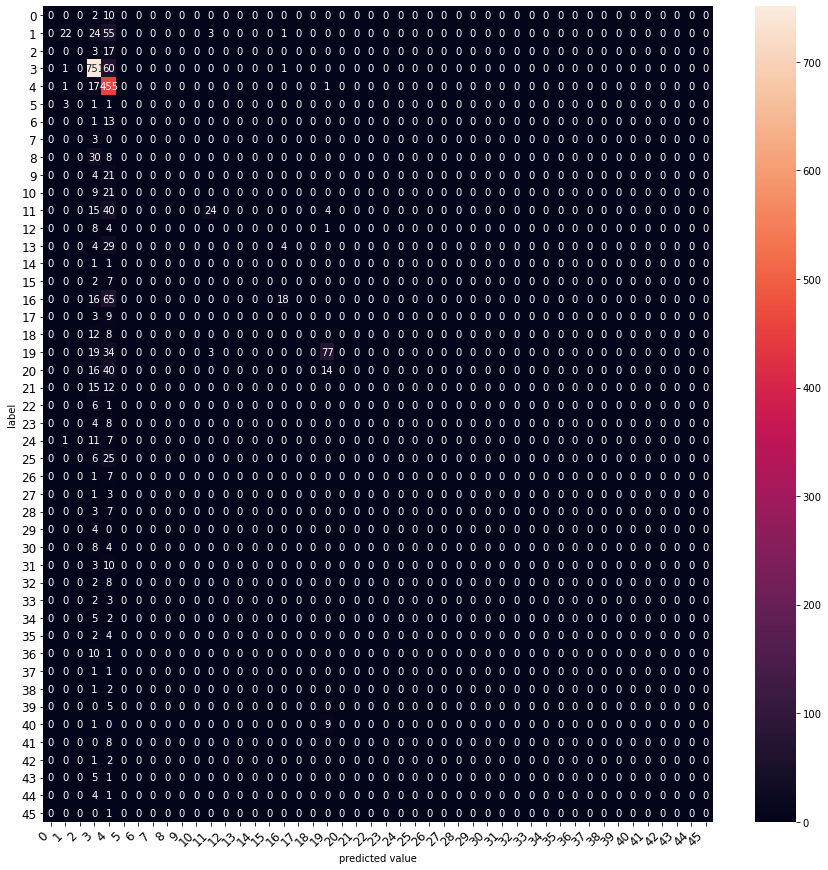

In [42]:
# 나이브 베이즈 분류기
print("[나이브 베이즈 분류기]")
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[나이브 베이즈 분류기의 Classification Report]")
print(classification_report(y_test, mod.predict(tfidfv_test)))
print("\n")      
print("[나이브 베이즈 분류기의 Confusion Matrix]")
graph_confusion_matrix(mod, tfidfv_test, y_test)

[CNB]
정확도: 0.7649154051647373


[CNB의 Classification Report]
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.63      0.88      0.73       105
           2       0.91      0.50      0.65        20
           3       0.87      0.91      0.89       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.43      0.08      0.13        38
           9       0.81      0.88      0.85        25
          10       0.96      0.73      0.83        30
          11       0.55      0.67      0.61        83
          12       0.00      0.00      0.00        13
          13       0.62      0.54      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

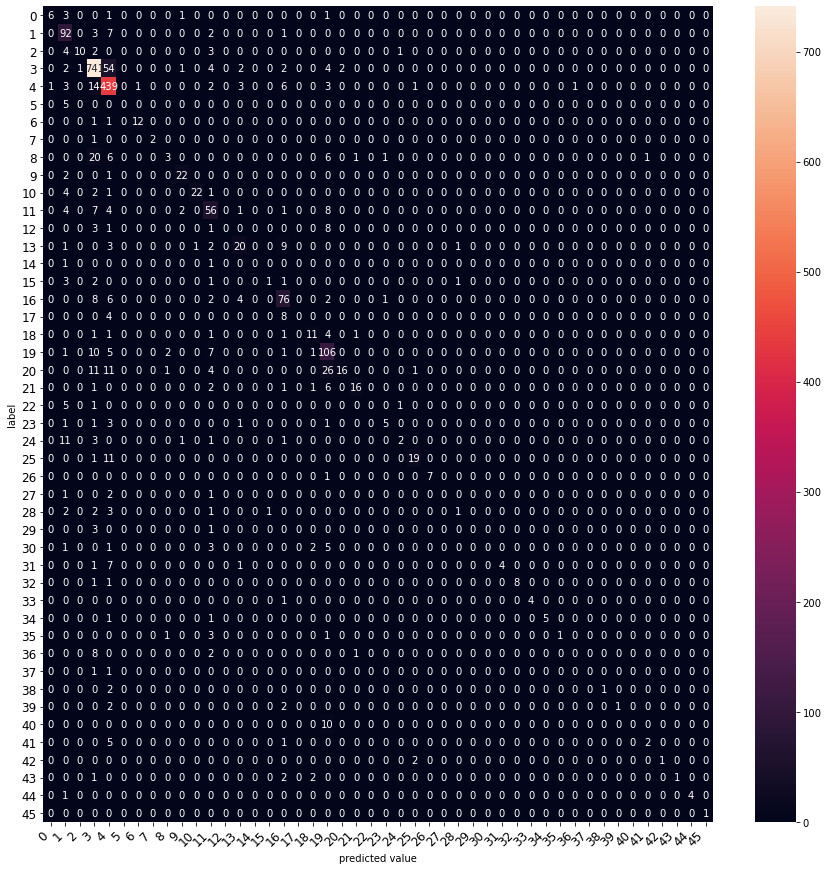

In [44]:
# CNB
print("[CNB]")
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[CNB의 Classification Report]")
print(classification_report(y_test, cb.predict(tfidfv_test)))
print("\n")
print("[CNB의 Confusion Matrix]")
graph_confusion_matrix(cb, tfidfv_test, y_test)

[로지스틱 회귀]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

정확도: 0.813446126447017


[로지스틱 회귀의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.80      0.77       105
           2       0.70      0.70      0.70        20
           3       0.93      0.93      0.93       813
           4       0.81      0.87      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      1.00      0.97        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.66      0.73      0.70        83
          12       0.57      0.31      0.40        13
          13       0.61      0.62      0.61        37
          14       0.67      1.00      0.80         2
          15       0.71      0.56      0.63         9
          16       0.71

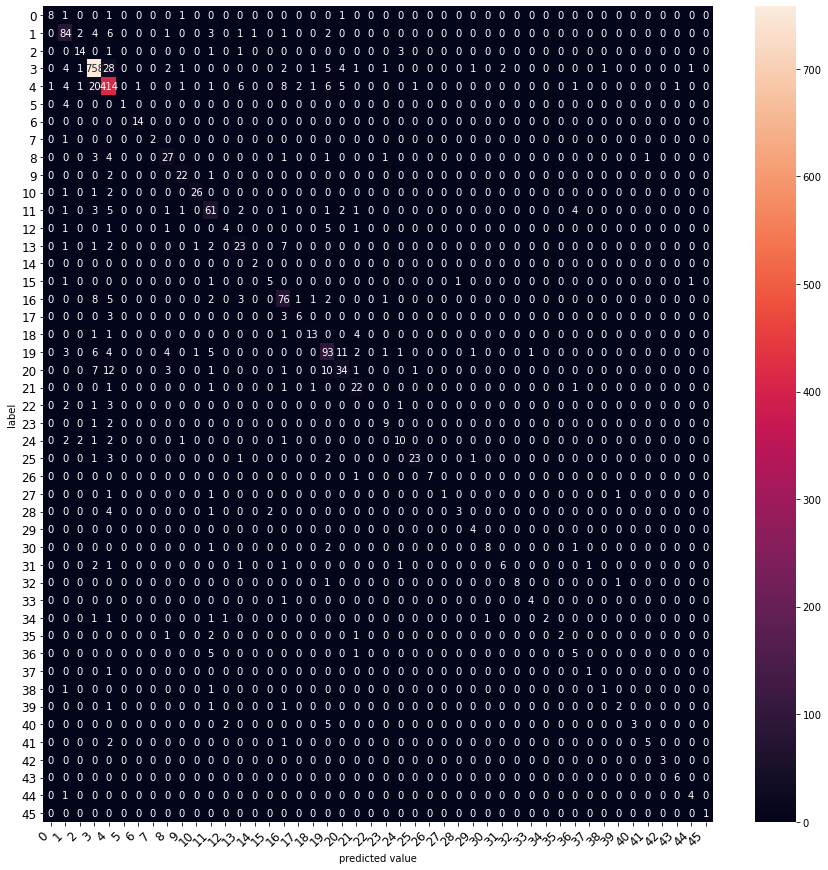

In [45]:
# 로지스틱 회귀
print("[로지스틱 회귀]")
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[로지스틱 회귀의 Classification Report]")
print(classification_report(y_test, lr.predict(tfidfv_test)))
print("\n")
print("[로지스틱 회귀의 Confusion Matrix]")
graph_confusion_matrix(lr, tfidfv_test, y_test)

[서포트 벡터 머신]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_class

정확도: 0.7853962600178095


[서포트 벡터 머신의 Classification Report]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.70      0.71      0.71       105
           2       0.68      0.75      0.71        20
           3       0.91      0.92      0.92       813
           4       0.80      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.60      0.71      0.65        38
           9       0.84      0.84      0.84        25
          10       0.83      0.83      0.83        30
          11       0.66      0.73      0.69        83
          12       0.43      0.23      0.30        13
          13       0.62      0.57      0.59        37
          14       0.33      0.50      0.40         2
          15       0.33      0.11      0.17         9
          16       0

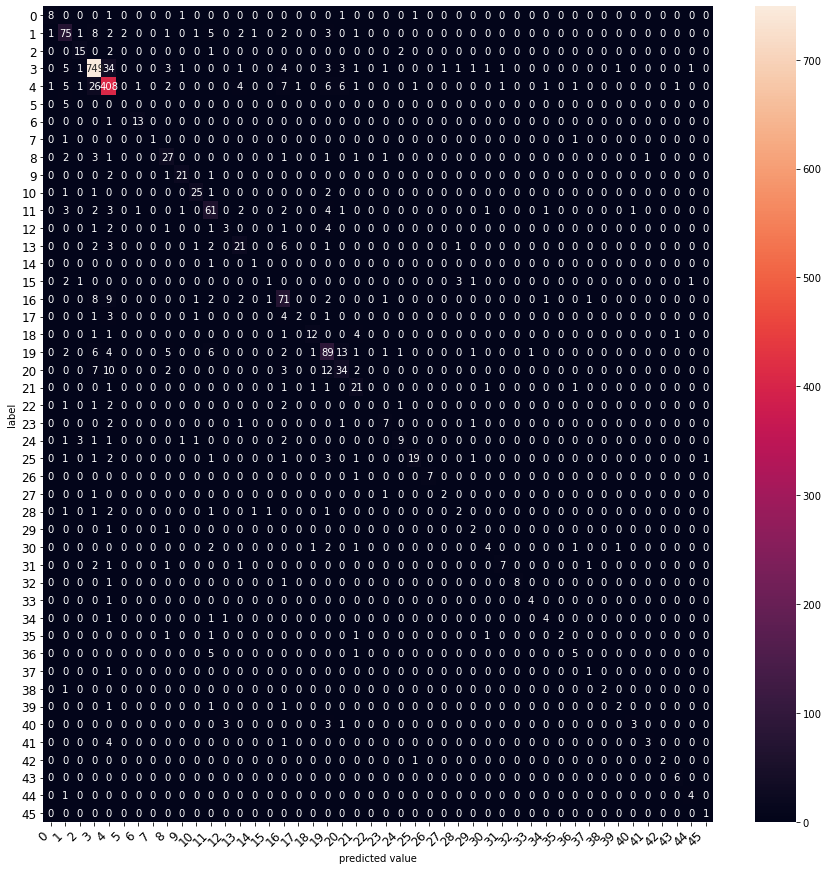

In [46]:
# 서포트 벡터 머신
print("[서포트 벡터 머신]")
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[서포트 벡터 머신의 Classification Report]")
print(classification_report(y_test, lsvc.predict(tfidfv_test)))
print("\n")
print("[서포트 벡터 머신의 Confusion Matrix]")
graph_confusion_matrix(lsvc, tfidfv_test, y_test)

[결정 트리]
정확도: 0.6211041852181657


[결정 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.69      0.43      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.85      0.89       813
           4       0.40      0.89      0.55       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.89      0.80      0.84        30
          11       0.58      0.60      0.59        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16    

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

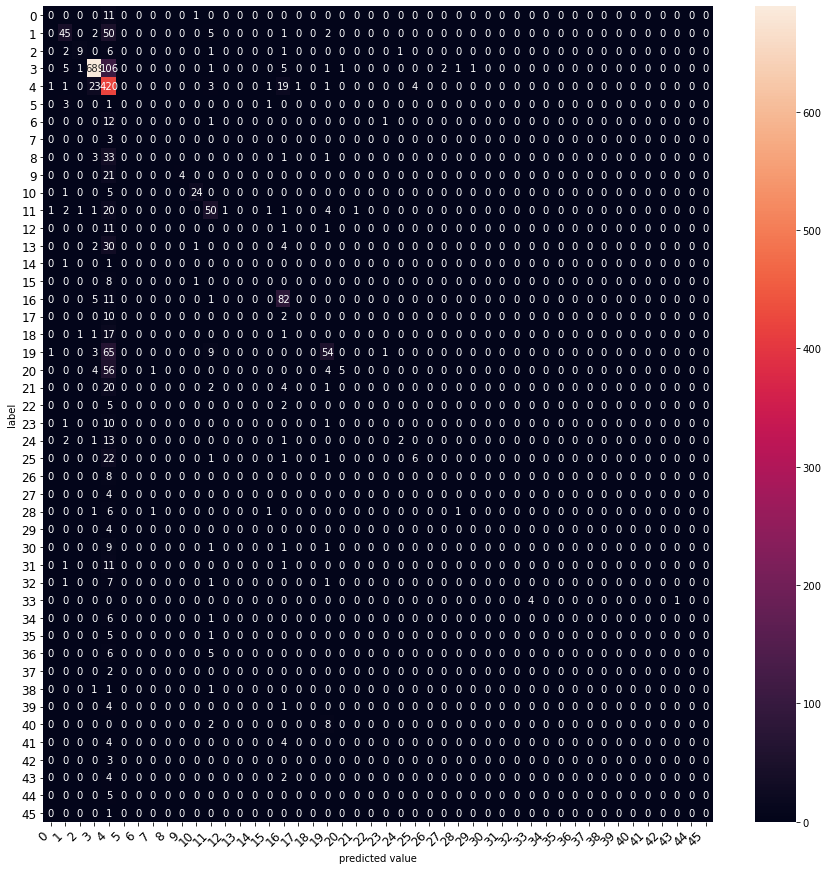

In [47]:
# 결정 트리
print("[결정 트리]")
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[결정 트리의 Classification Report]")
print(classification_report(y_test, tree.predict(tfidfv_test)))
print("\n")
print("[결정 트리의 Confusion Matrix]")
graph_confusion_matrix(tree, tfidfv_test, y_test)

[랜덤 포레스트]
정확도: 0.6544968833481746


[랜덤 포레스트의 Classification Report]
              precision    recall  f1-score   support

           0       0.25      0.58      0.35        12
           1       0.35      0.60      0.44       105
           2       0.32      0.40      0.36        20
           3       0.82      0.89      0.85       813
           4       0.62      0.84      0.71       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.51      0.47      0.49        38
           9       1.00      0.28      0.44        25
          10       0.46      0.20      0.28        30
          11       0.56      0.64      0.60        83
          12       0.40      0.15      0.22        13
          13       0.33      0.16      0.22        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

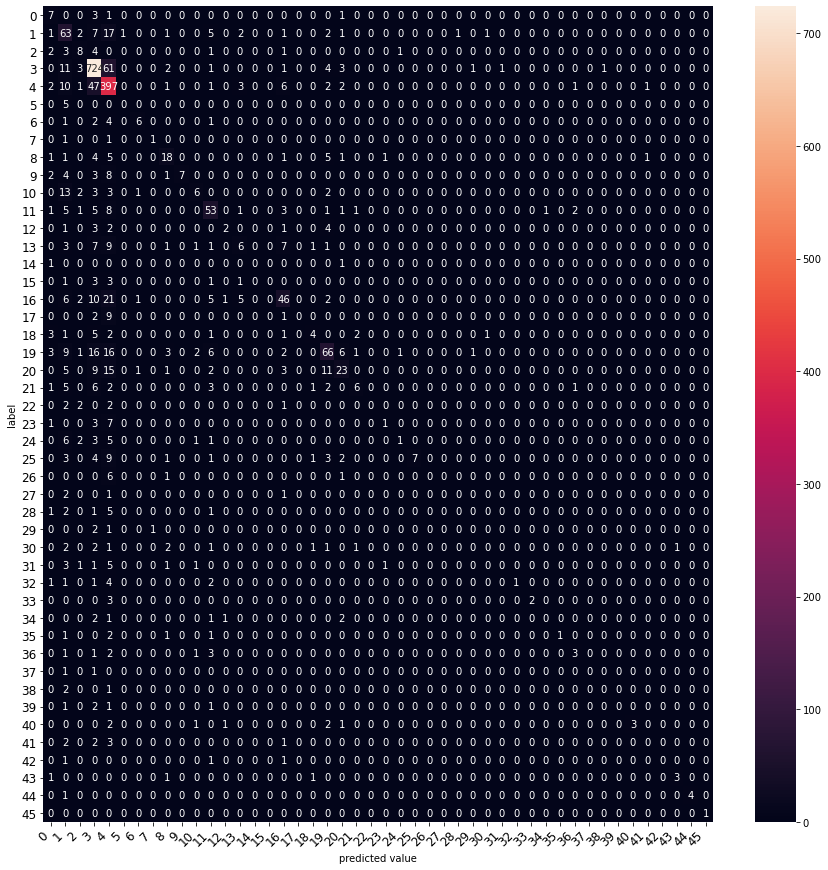

In [48]:
# 랜덤 포레스트
print("[랜덤 포레스트]")
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[랜덤 포레스트의 Classification Report]")
print(classification_report(y_test, forest.predict(tfidfv_test)))
print("\n")
print("[랜덤 포레스트의 Confusion Matrix]")
graph_confusion_matrix(forest, tfidfv_test, y_test)

[그래디언트 부스팅 트리]
정확도: 0.7702582368655387


[그래디언트 부스팅 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.81      0.71      0.76       105
           2       0.58      0.70      0.64        20
           3       0.87      0.91      0.89       813
           4       0.78      0.86      0.82       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.60      0.63      0.62        38
           9       0.91      0.80      0.85        25
          10       0.79      0.77      0.78        30
          11       0.61      0.65      0.63        83
          12       0.50      0.46      0.48        13
          13       0.48      0.32      0.39        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
  

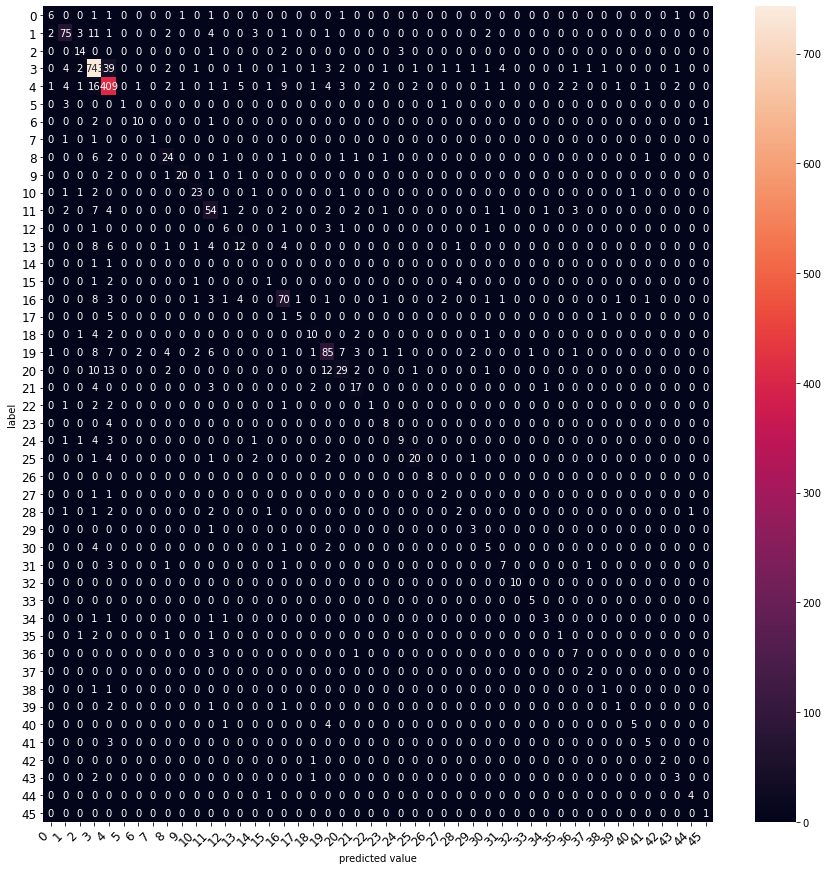

In [49]:
# 그래디언트 부스팅 트리
print("[그래디언트 부스팅 트리]")
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[그래디언트 부스팅 트리의 Classification Report]")
print(classification_report(y_test, grbt.predict(tfidfv_test)))
print("\n")
print("[그래디언트 부스팅 트리의 Confusion Matrix]")
graph_confusion_matrix(grbt, tfidfv_test, y_test)

[보팅]
정확도: 0.8187889581478184


[보팅의 Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.80      0.77      0.79       105
           2       0.67      0.80      0.73        20
           3       0.93      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.80      0.80      0.80        25
          10       0.90      0.90      0.90        30
          11       0.67      0.71      0.69        83
          12       0.60      0.46      0.52        13
          13       0.69      0.65      0.67        37
          14       0.29      1.00      0.44         2
          15       0.40      0.22      0.29         9
          16       0.7

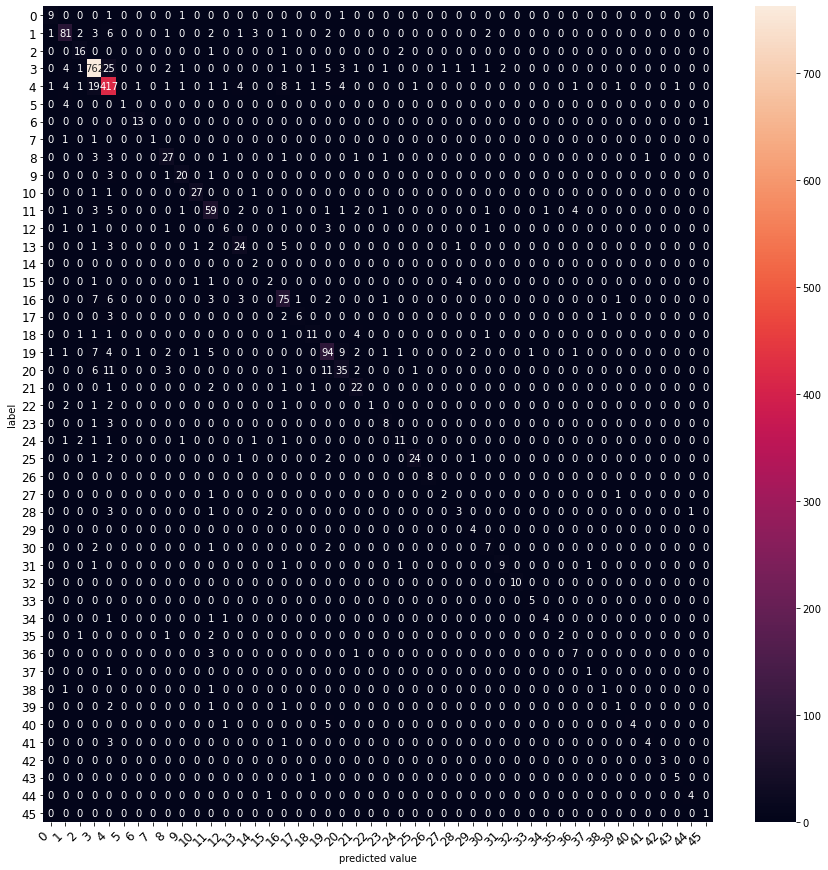

In [50]:
# 보팅
print("[보팅]")
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[보팅의 Classification Report]")
print(classification_report(y_test, voting_classifier.predict(tfidfv_test)))
print("\n")
print("[보팅의 Confusion Matrix]")
graph_confusion_matrix(voting_classifier, tfidfv_test, y_test)

****
## 2. 빈도수 상위 5,000개의 단어만 사용

In [3]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 4867)
(8982, 4867)


[나이브 베이즈 분류기]
- 정확도: 0.6731967943009796


[나이브 베이즈 분류기의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
  

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

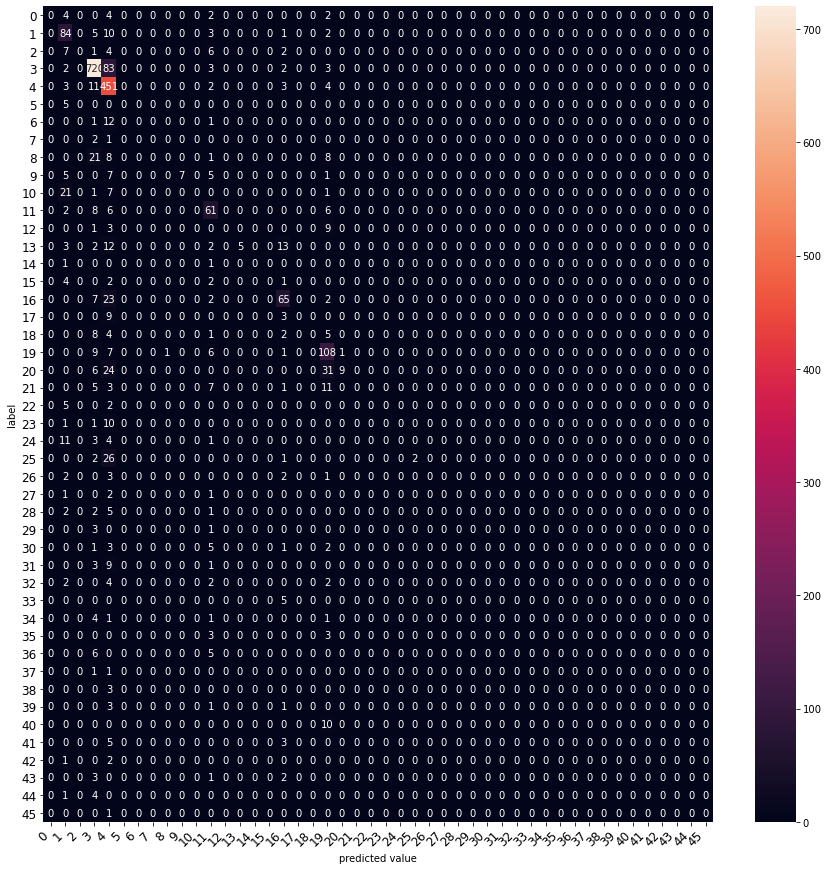

In [7]:
# 나이브 베이즈 분류기
print("[나이브 베이즈 분류기]")
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[나이브 베이즈 분류기의 Classification Report]")
print(classification_report(y_test, mod.predict(tfidfv_test)))
print("\n")      
print("[나이브 베이즈 분류기의 Confusion Matrix]")
graph_confusion_matrix(mod, tfidfv_test, y_test)

[CNB]
정확도: 0.7707034728406055


[CNB의 Classification Report]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.63      0.86      0.73       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.74      0.92      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.57      0.21      0.31        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.76      0.63        83
          12       0.00      0.00      0.00        13
          13       0.69      0.59      0.64        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

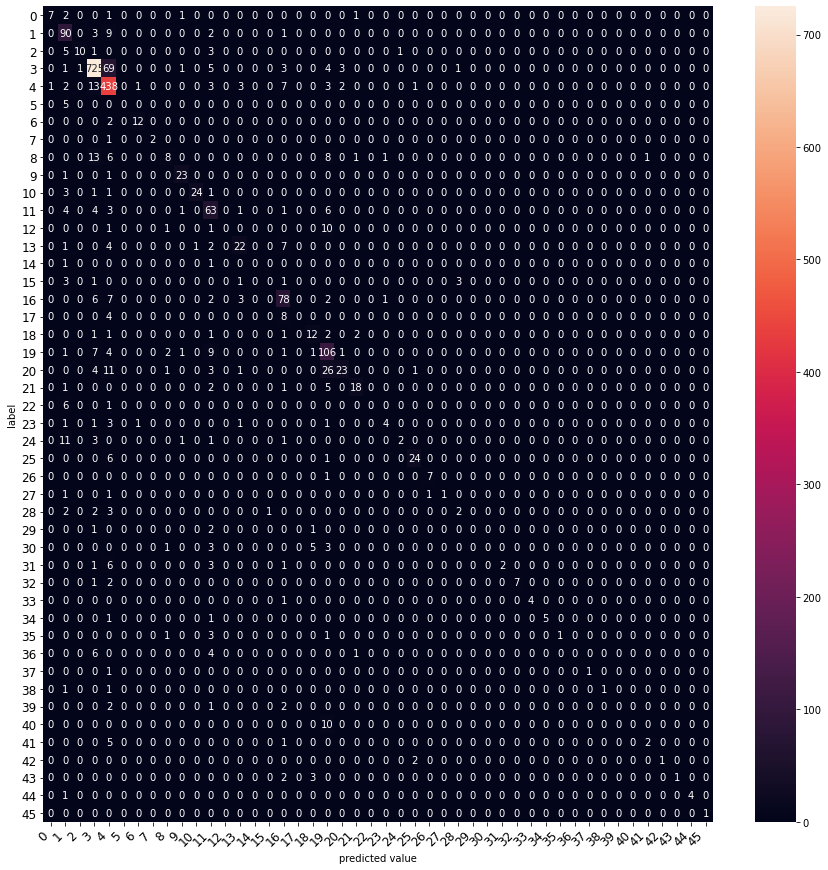

In [8]:
# CNB
print("[CNB]")
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[CNB의 Classification Report]")
print(classification_report(y_test, cb.predict(tfidfv_test)))
print("\n")
print("[CNB의 Confusion Matrix]")
graph_confusion_matrix(cb, tfidfv_test, y_test)

[로지스틱 회귀]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

정확도: 0.8058771148708815


[로지스틱 회귀의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.80      0.79       105
           2       0.74      0.85      0.79        20
           3       0.91      0.93      0.92       813
           4       0.81      0.87      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.64      0.74      0.68        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.64      0.73      0.68        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.50      0.50      0.50         2
          15       0.83      0.56      0.67         9
          16       0.6

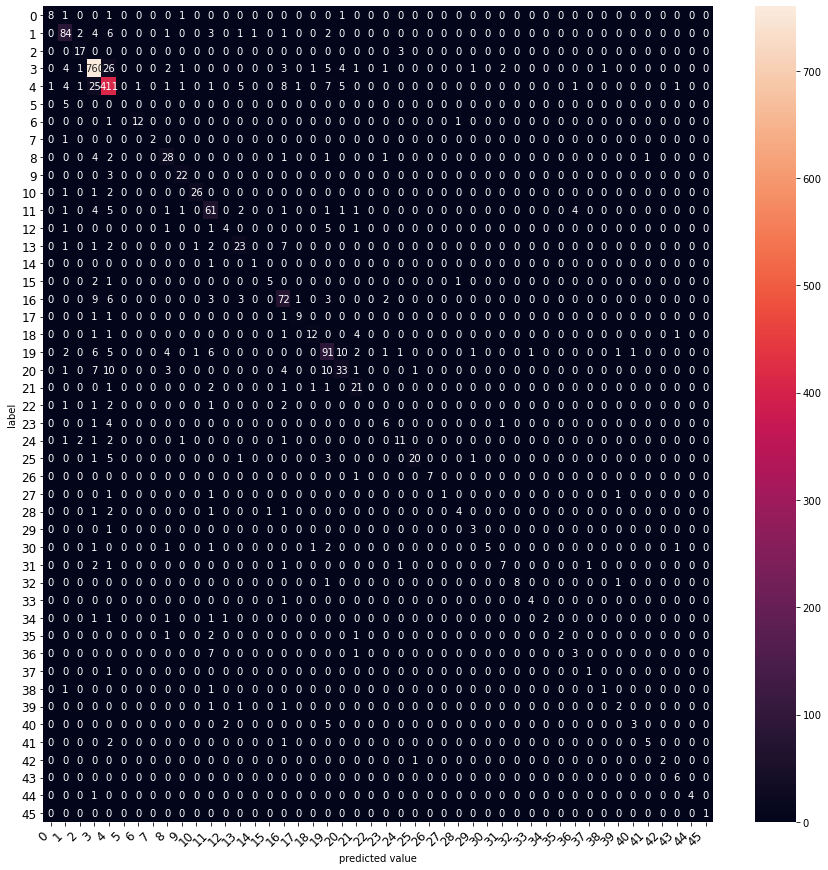

In [9]:
# 로지스틱 회귀
print("[로지스틱 회귀]")
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[로지스틱 회귀의 Classification Report]")
print(classification_report(y_test, lr.predict(tfidfv_test)))
print("\n")
print("[로지스틱 회귀의 Confusion Matrix]")
graph_confusion_matrix(lr, tfidfv_test, y_test)

[서포트 벡터 머신]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


정확도: 0.7684772929652716


[서포트 벡터 머신의 Classification Report]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.72      0.72      0.72       105
           2       0.68      0.65      0.67        20
           3       0.90      0.90      0.90       813
           4       0.80      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       0.81      0.93      0.87        14
           7       1.00      0.33      0.50         3
           8       0.56      0.71      0.63        38
           9       0.83      0.80      0.82        25
          10       0.77      0.77      0.77        30
          11       0.65      0.72      0.68        83
          12       0.29      0.31      0.30        13
          13       0.64      0.62      0.63        37
          14       0.50      0.50      0.50         2
          15       0.50      0.22      0.31         9
          16       0

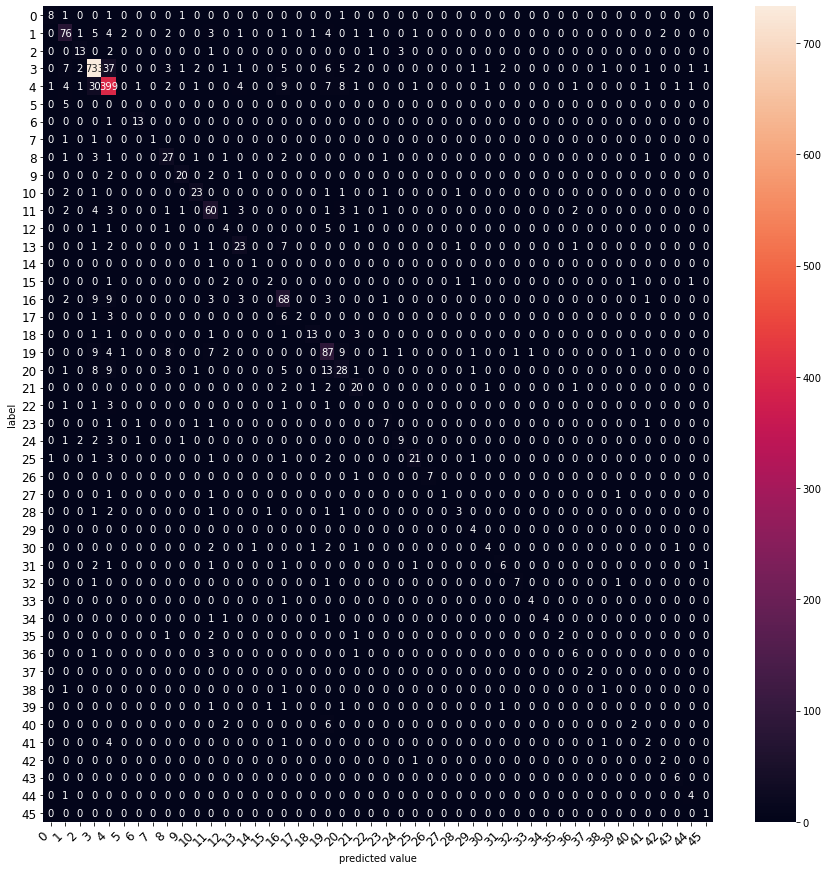

In [10]:
# 서포트 벡터 머신
print("[서포트 벡터 머신]")
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[서포트 벡터 머신의 Classification Report]")
print(classification_report(y_test, lsvc.predict(tfidfv_test)))
print("\n")
print("[서포트 벡터 머신의 Confusion Matrix]")
graph_confusion_matrix(lsvc, tfidfv_test, y_test)

[결정 트리]
정확도: 0.6179875333926982


[결정 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.40      0.52       105
           2       0.60      0.45      0.51        20
           3       0.94      0.84      0.89       813
           4       0.39      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       1.00      0.57      0.73        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.62      0.48      0.54        83
          12       0.17      0.08      0.11        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16    

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

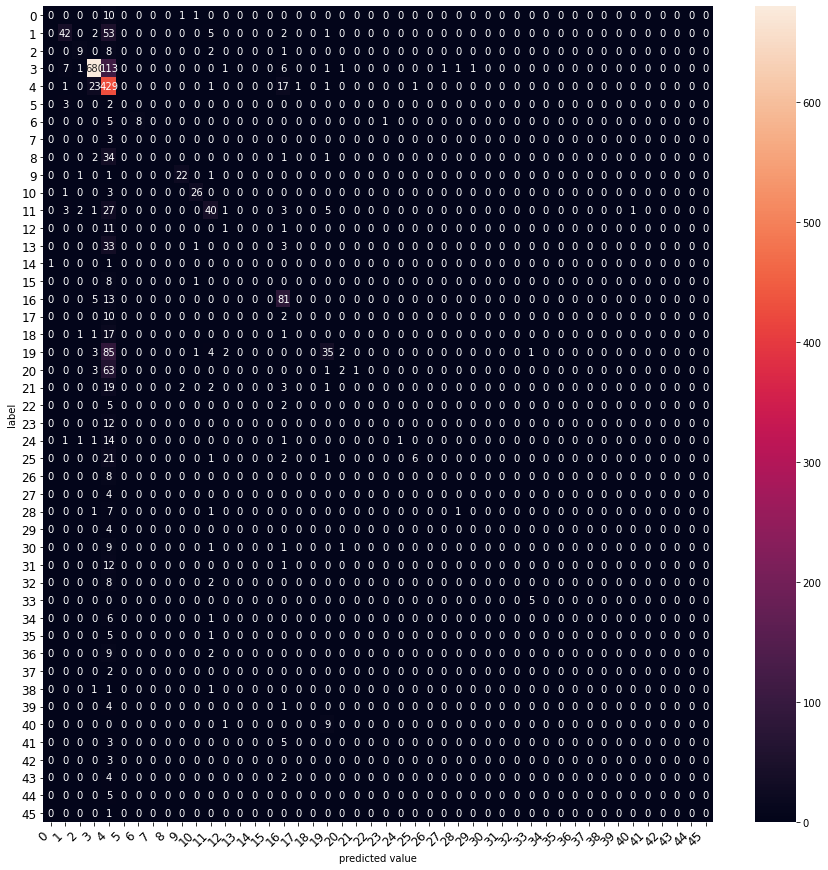

In [11]:
# 결정 트리
print("[결정 트리]")
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[결정 트리의 Classification Report]")
print(classification_report(y_test, tree.predict(tfidfv_test)))
print("\n")
print("[결정 트리의 Confusion Matrix]")
graph_confusion_matrix(tree, tfidfv_test, y_test)

[랜덤 포레스트]
정확도: 0.701246660730187


[랜덤 포레스트의 Classification Report]
              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16 

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

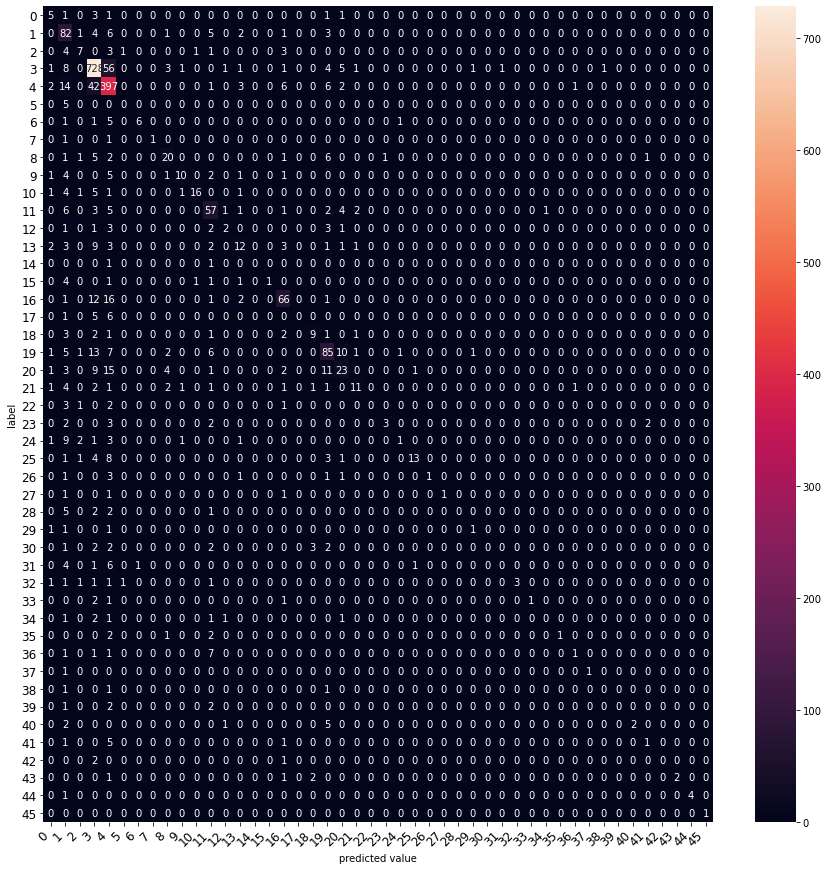

In [12]:
# 랜덤 포레스트
print("[랜덤 포레스트]")
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[랜덤 포레스트의 Classification Report]")
print(classification_report(y_test, forest.predict(tfidfv_test)))
print("\n")
print("[랜덤 포레스트의 Confusion Matrix]")
graph_confusion_matrix(forest, tfidfv_test, y_test)

[그래디언트 부스팅 트리]
정확도: 0.767586821015138


[그래디언트 부스팅 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87      0.87      0.87        30
          11       0.62      0.66      0.64        83
          12       0.46      0.46      0.46        13
          13       0.55      0.43      0.48        37
          14       0.08      0.50      0.14         2
          15       0.33      0.22      0.27         9
   

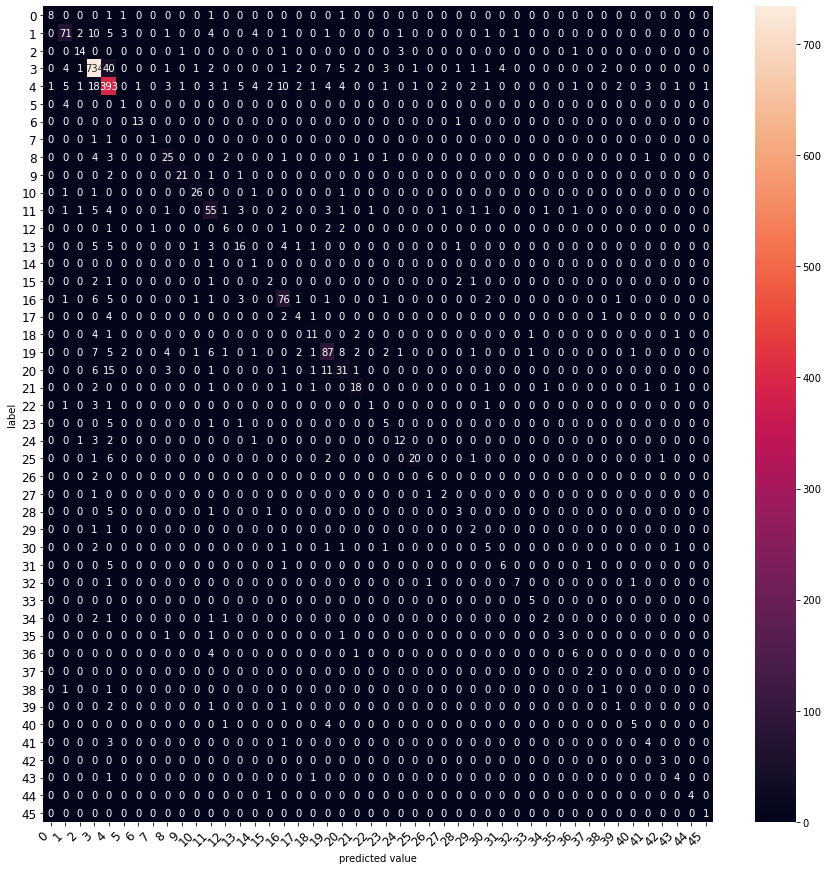

In [13]:
# 그래디언트 부스팅 트리
print("[그래디언트 부스팅 트리]")
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[그래디언트 부스팅 트리의 Classification Report]")
print(classification_report(y_test, grbt.predict(tfidfv_test)))
print("\n")
print("[그래디언트 부스팅 트리의 Confusion Matrix]")
graph_confusion_matrix(grbt, tfidfv_test, y_test)

[보팅]
정확도: 0.8161175422974176


[보팅의 Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.77      0.79       105
           2       0.71      0.85      0.77        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       0.33      0.20      0.25         5
           6       0.93      0.93      0.93        14
           7       0.67      0.67      0.67         3
           8       0.72      0.68      0.70        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.67      0.70      0.68        83
          12       0.60      0.46      0.52        13
          13       0.68      0.62      0.65        37
          14       0.12      0.50      0.20         2
          15       0.67      0.44      0.53         9
          16       0.7

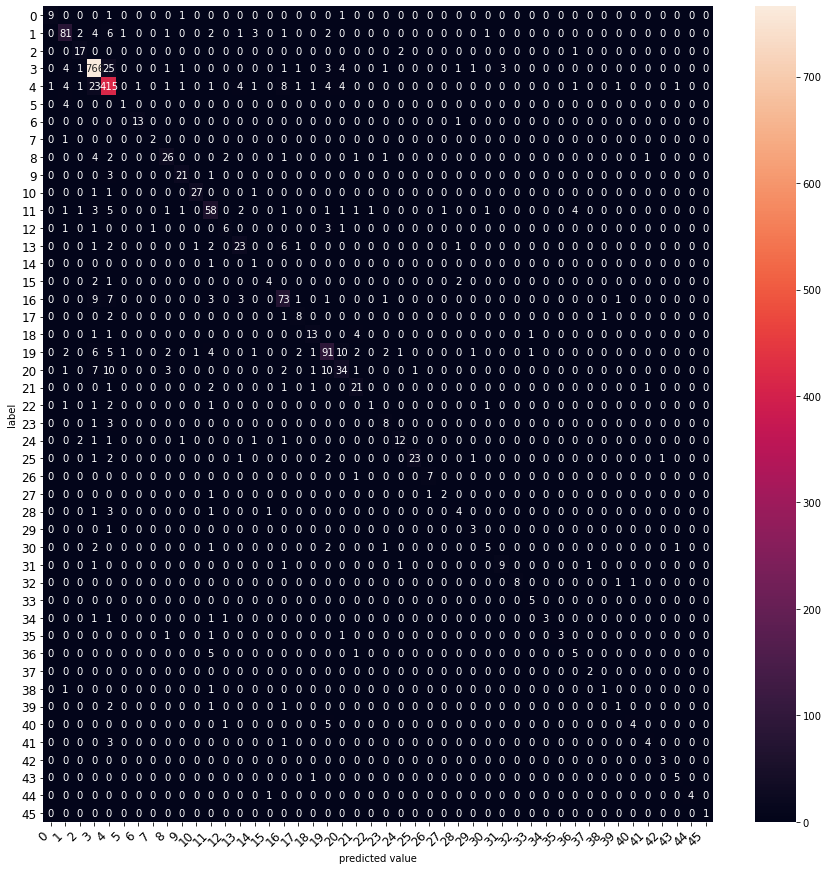

In [14]:
# 보팅
print("[보팅]")
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[보팅의 Classification Report]")
print(classification_report(y_test, voting_classifier.predict(tfidfv_test)))
print("\n")
print("[보팅의 Confusion Matrix]")
graph_confusion_matrix(voting_classifier, tfidfv_test, y_test)

## 3. 직접 단어 개수를 설정해서 사용

- 위 단계에서 5,000으로 제시된 ```num_words```를 다양하게 바꾸어 가며 성능을 확인해보자. 
- 변화된 단어 수에 따른 모델의 성능을 연구해보자.
- 최소 3가지 경우 이상을 시험해보길 바란다.

> <사용할 모델>
> - 나이브 베이즈 분류기
> - CNB
> - 로지스틱 회귀
> - 서포트 벡터 머신
> - 결정 트리
> - 랜덤 포레스트
> - 그래디언트 부스팅 트리
> - 보팅


### num_words = 20000일 경우

In [17]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=20000, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 18479)
(8982, 18479)


[나이브 베이즈 분류기]
- 정확도: 0.6193232413178985


[나이브 베이즈 분류기의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.39      0.52       105
           2       0.00      0.00      0.00        20
           3       0.75      0.92      0.82       813
           4       0.46      0.96      0.62       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.76      0.37      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
  

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

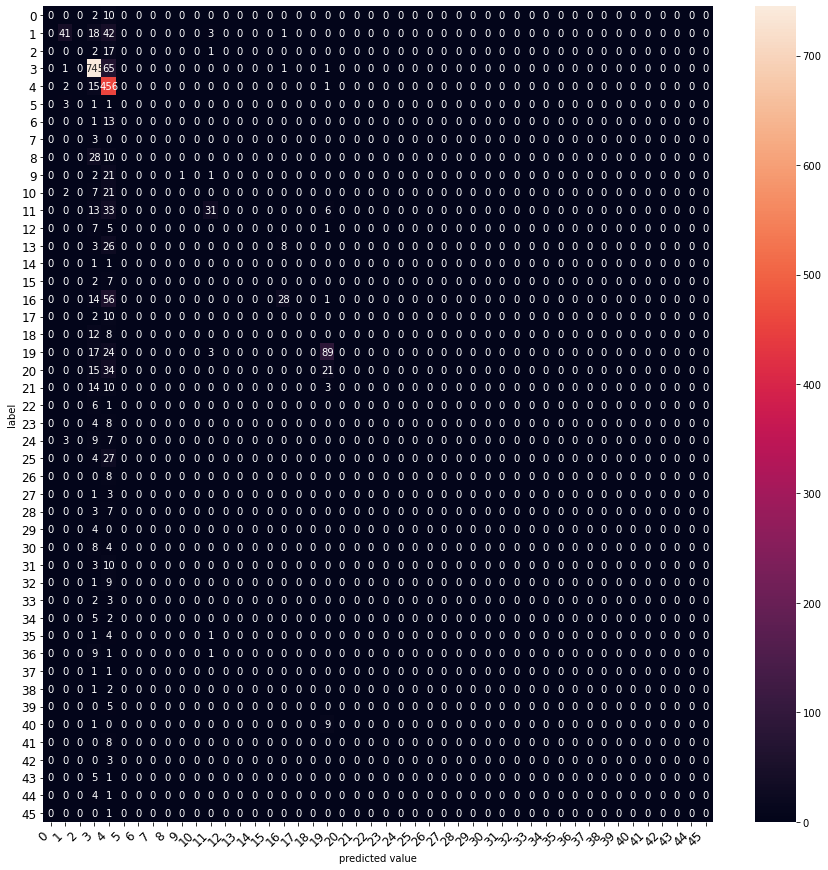

In [18]:
# 나이브 베이즈 분류기
print("[나이브 베이즈 분류기]")
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[나이브 베이즈 분류기의 Classification Report]")
print(classification_report(y_test, mod.predict(tfidfv_test)))
print("\n")      
print("[나이브 베이즈 분류기의 Confusion Matrix]")
graph_confusion_matrix(mod, tfidfv_test, y_test)

[CNB]
정확도: 0.7671415850400712


[CNB의 Classification Report]
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.64      0.89      0.74       105
           2       0.91      0.50      0.65        20
           3       0.89      0.91      0.90       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.44      0.11      0.17        38
           9       0.82      0.92      0.87        25
          10       0.96      0.73      0.83        30
          11       0.54      0.70      0.61        83
          12       0.00      0.00      0.00        13
          13       0.61      0.54      0.57        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

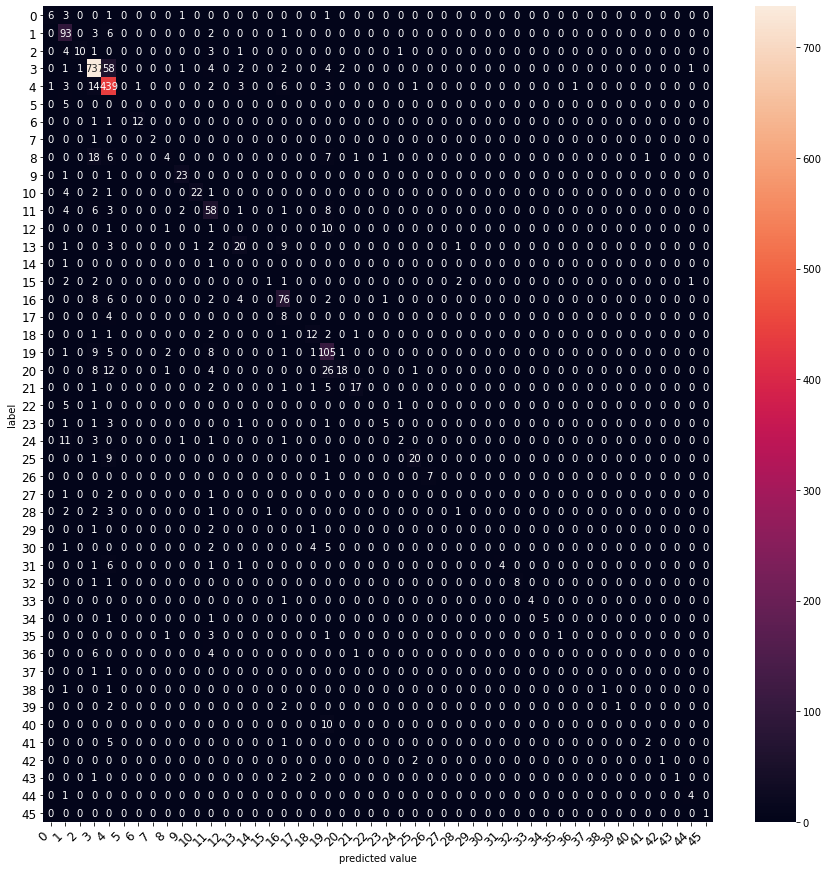

In [19]:
# CNB
print("[CNB]")
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[CNB의 Classification Report]")
print(classification_report(y_test, cb.predict(tfidfv_test)))
print("\n")
print("[CNB의 Confusion Matrix]")
graph_confusion_matrix(cb, tfidfv_test, y_test)

[로지스틱 회귀]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

정확도: 0.8098842386464826


[로지스틱 회귀의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.78      0.76       105
           2       0.70      0.70      0.70        20
           3       0.92      0.93      0.92       813
           4       0.82      0.88      0.85       474
           5       0.00      0.00      0.00         5
           6       0.93      1.00      0.97        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.82      0.92      0.87        25
          10       0.93      0.87      0.90        30
          11       0.65      0.73      0.69        83
          12       0.57      0.31      0.40        13
          13       0.57      0.62      0.60        37
          14       0.67      1.00      0.80         2
          15       0.67      0.44      0.53         9
          16       0.7

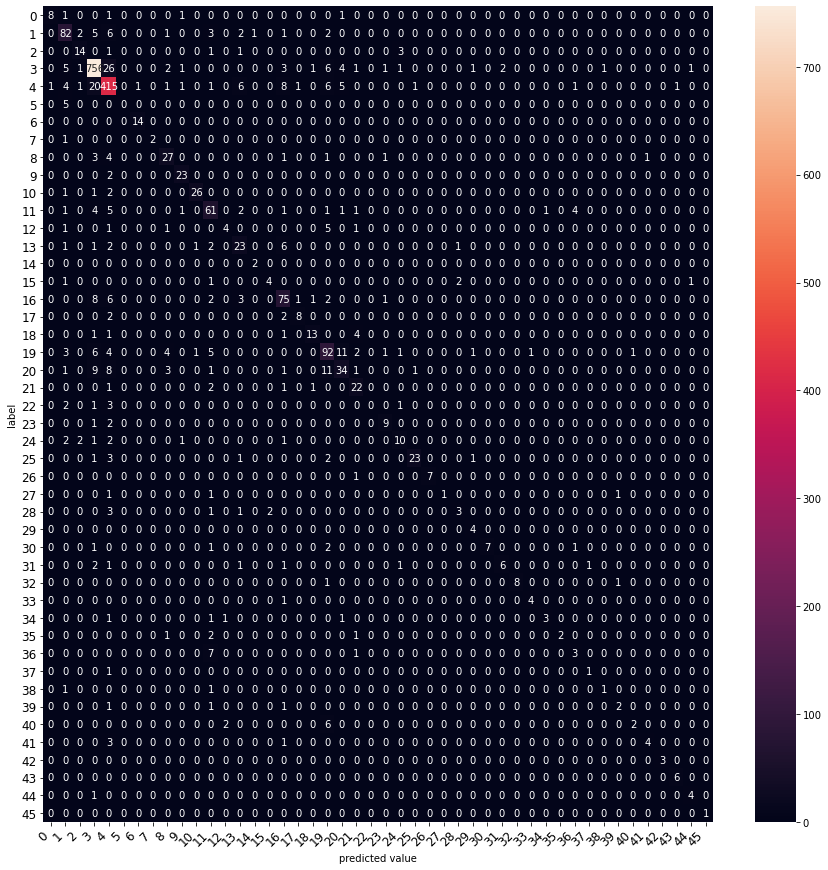

In [20]:
# 로지스틱 회귀
print("[로지스틱 회귀]")
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[로지스틱 회귀의 Classification Report]")
print(classification_report(y_test, lr.predict(tfidfv_test)))
print("\n")
print("[로지스틱 회귀의 Confusion Matrix]")
graph_confusion_matrix(lr, tfidfv_test, y_test)

[서포트 벡터 머신]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


정확도: 0.7809439002671416


[서포트 벡터 머신의 Classification Report]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.68      0.72      0.70       105
           2       0.76      0.65      0.70        20
           3       0.91      0.92      0.91       813
           4       0.81      0.85      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.59      0.68      0.63        38
           9       0.75      0.84      0.79        25
          10       0.90      0.87      0.88        30
          11       0.61      0.69      0.65        83
          12       0.38      0.38      0.38        13
          13       0.54      0.54      0.54        37
          14       0.33      0.50      0.40         2
          15       0.75      0.33      0.46         9
          16       0

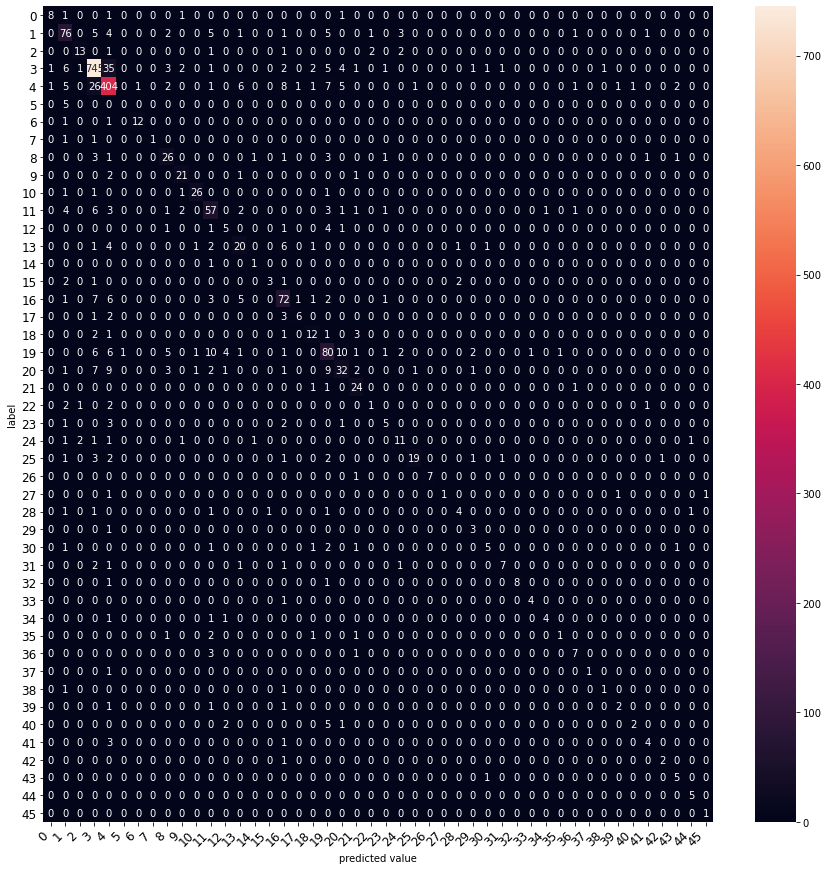

In [21]:
# 서포트 벡터 머신
print("[서포트 벡터 머신]")
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[서포트 벡터 머신의 Classification Report]")
print(classification_report(y_test, lsvc.predict(tfidfv_test)))
print("\n")
print("[서포트 벡터 머신의 Confusion Matrix]")
graph_confusion_matrix(lsvc, tfidfv_test, y_test)

[결정 트리]
정확도: 0.6211041852181657


[결정 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.39      0.51       105
           2       0.50      0.55      0.52        20
           3       0.93      0.85      0.88       813
           4       0.40      0.89      0.55       474
           5       0.00      0.00      0.00         5
           6       0.75      0.21      0.33        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.89      0.80      0.84        30
          11       0.61      0.61      0.61        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16    

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

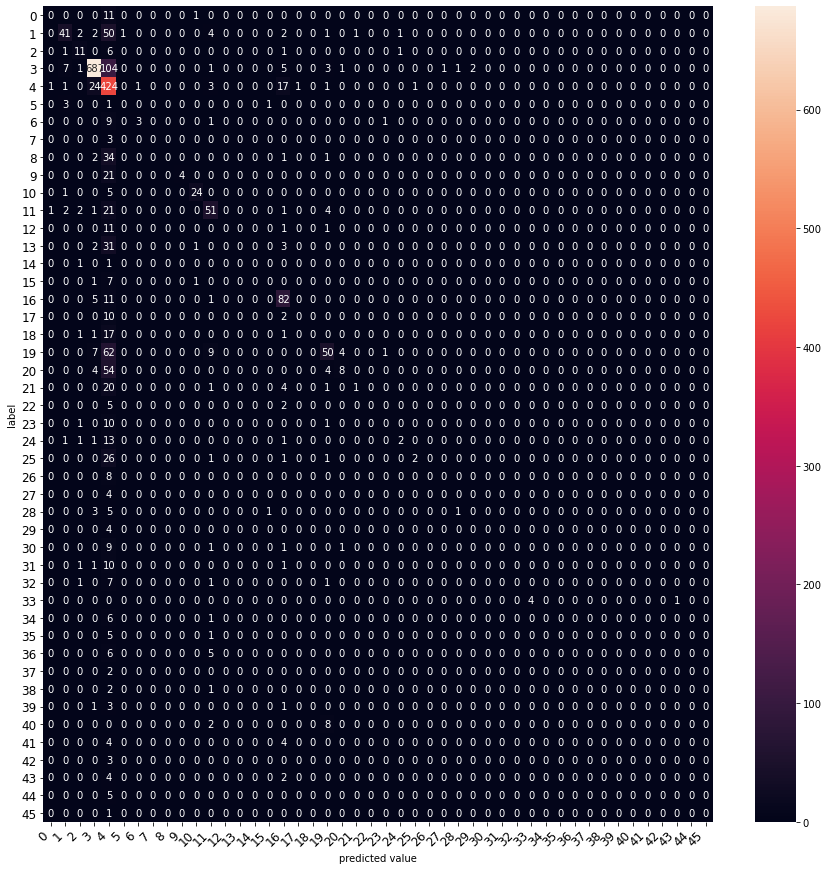

In [22]:
# 결정 트리
print("[결정 트리]")
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[결정 트리의 Classification Report]")
print(classification_report(y_test, tree.predict(tfidfv_test)))
print("\n")
print("[결정 트리의 Confusion Matrix]")
graph_confusion_matrix(tree, tfidfv_test, y_test)

[랜덤 포레스트]
정확도: 0.6714158504007124


[랜덤 포레스트의 Classification Report]
              precision    recall  f1-score   support

           0       0.17      0.33      0.23        12
           1       0.40      0.70      0.51       105
           2       0.19      0.20      0.20        20
           3       0.83      0.91      0.87       813
           4       0.65      0.86      0.74       474
           5       0.00      0.00      0.00         5
           6       1.00      0.29      0.44        14
           7       0.33      0.33      0.33         3
           8       0.48      0.42      0.45        38
           9       0.54      0.28      0.37        25
          10       0.53      0.27      0.36        30
          11       0.49      0.57      0.53        83
          12       0.50      0.15      0.24        13
          13       0.43      0.27      0.33        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

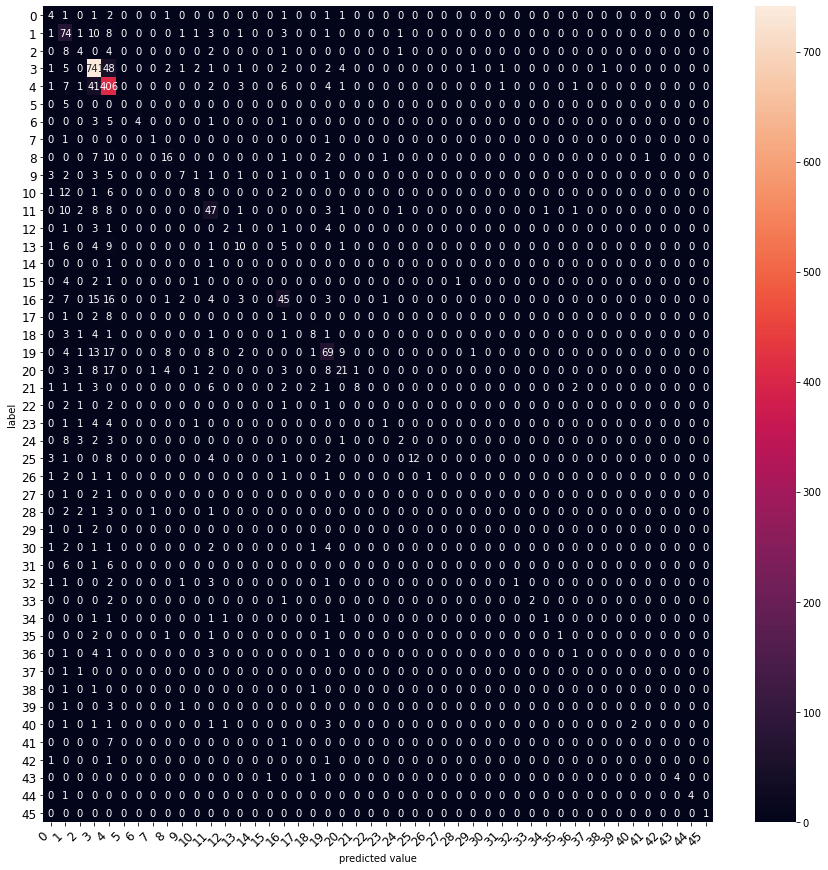

In [23]:
# 랜덤 포레스트
print("[랜덤 포레스트]")
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[랜덤 포레스트의 Classification Report]")
print(classification_report(y_test, forest.predict(tfidfv_test)))
print("\n")
print("[랜덤 포레스트의 Confusion Matrix]")
graph_confusion_matrix(forest, tfidfv_test, y_test)

[그래디언트 부스팅 트리]
정확도: 0.769813000890472


[그래디언트 부스팅 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.76      0.69      0.72       105
           2       0.60      0.75      0.67        20
           3       0.87      0.91      0.89       813
           4       0.77      0.84      0.81       474
           5       0.50      0.20      0.29         5
           6       0.91      0.71      0.80        14
           7       0.25      0.33      0.29         3
           8       0.60      0.63      0.62        38
           9       0.90      0.76      0.83        25
          10       0.80      0.80      0.80        30
          11       0.62      0.67      0.65        83
          12       0.50      0.46      0.48        13
          13       0.54      0.35      0.43        37
          14       0.14      0.50      0.22         2
          15       0.33      0.33      0.33         9
   

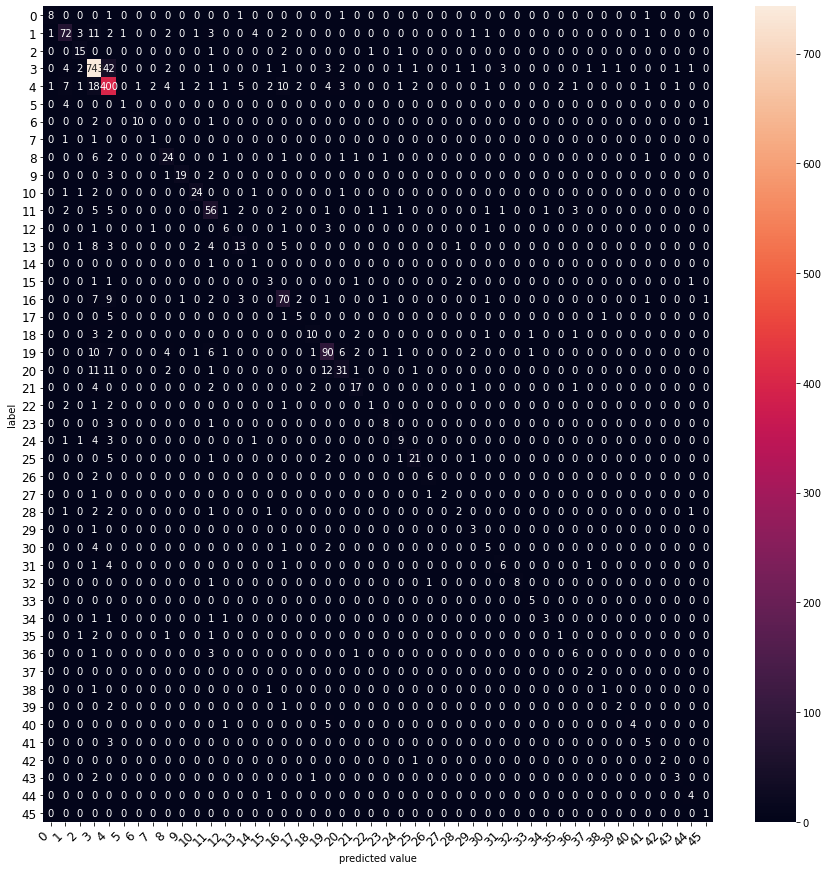

In [24]:
# 그래디언트 부스팅 트리
print("[그래디언트 부스팅 트리]")
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[그래디언트 부스팅 트리의 Classification Report]")
print(classification_report(y_test, grbt.predict(tfidfv_test)))
print("\n")
print("[그래디언트 부스팅 트리의 Confusion Matrix]")
graph_confusion_matrix(grbt, tfidfv_test, y_test)

[보팅]
정확도: 0.8178984861976848


[보팅의 Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.75      0.77       105
           2       0.70      0.80      0.74        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.80      0.80      0.80        25
          10       0.90      0.90      0.90        30
          11       0.69      0.71      0.70        83
          12       0.67      0.46      0.55        13
          13       0.63      0.65      0.64        37
          14       0.25      1.00      0.40         2
          15       0.57      0.44      0.50         9
          16       0.7

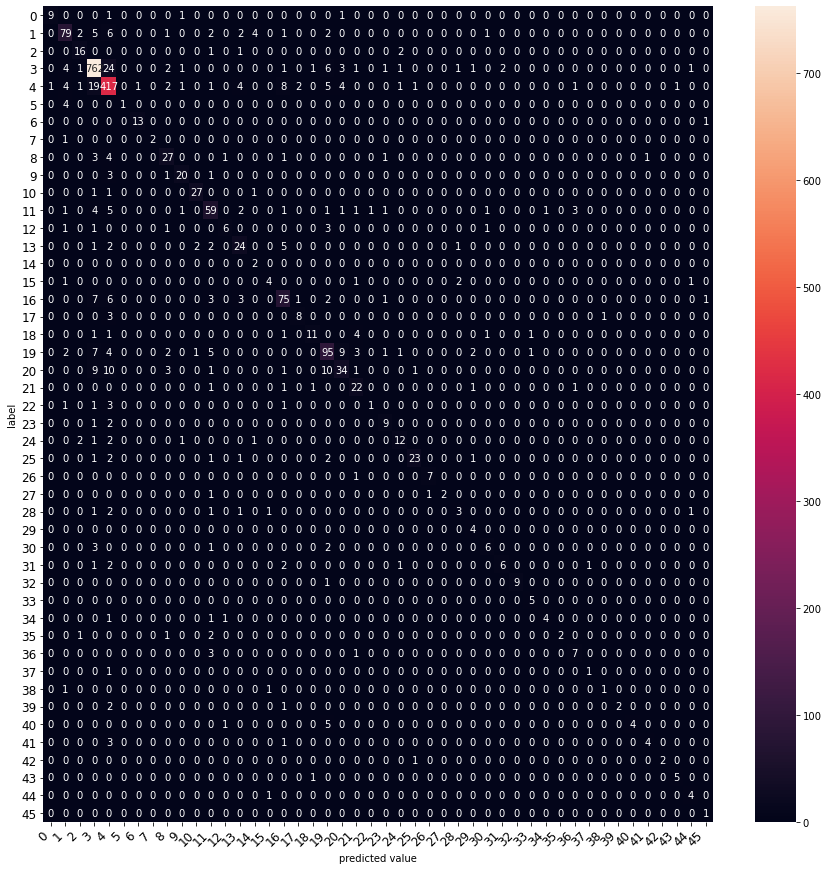

In [25]:
# 보팅
print("[보팅]")
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[보팅의 Classification Report]")
print(classification_report(y_test, voting_classifier.predict(tfidfv_test)))
print("\n")
print("[보팅의 Confusion Matrix]")
graph_confusion_matrix(voting_classifier, tfidfv_test, y_test)

### num_words = 15000일 경우 

In [26]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 14227)
(8982, 14227)


[나이브 베이즈 분류기]
- 정확도: 0.6331255565449688


[나이브 베이즈 분류기의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
  

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

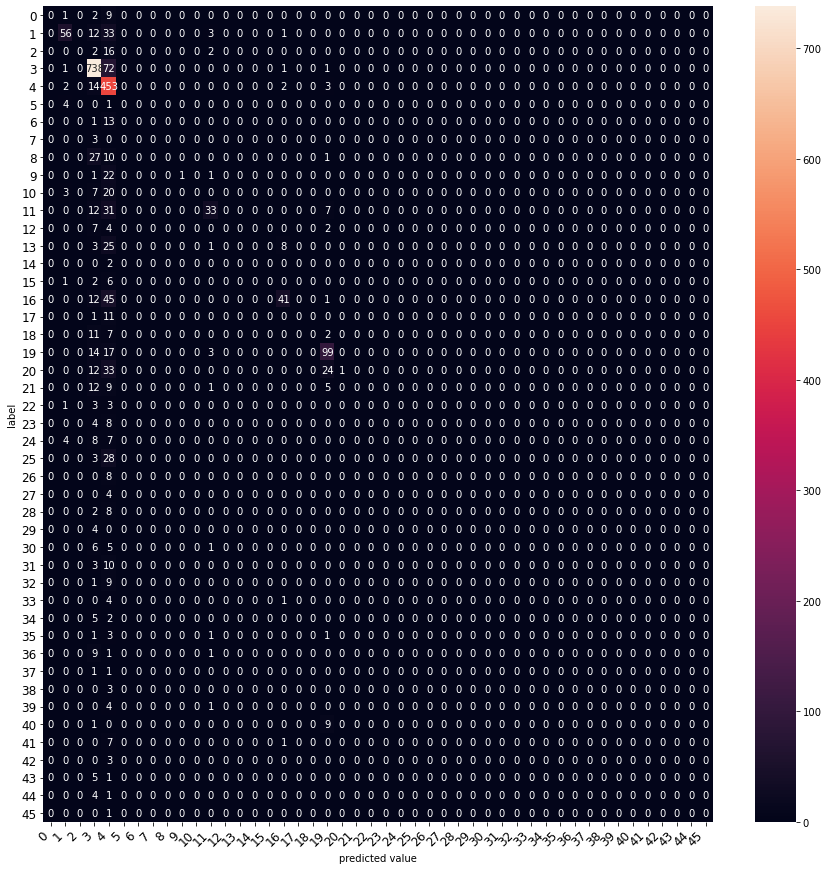

In [27]:
# 나이브 베이즈 분류기
print("[나이브 베이즈 분류기]")
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[나이브 베이즈 분류기의 Classification Report]")
print(classification_report(y_test, mod.predict(tfidfv_test)))
print("\n")      
print("[나이브 베이즈 분류기의 Confusion Matrix]")
graph_confusion_matrix(mod, tfidfv_test, y_test)

[CNB]
정확도: 0.7720391807658059


[CNB의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.65      0.90      0.76       105
           2       0.91      0.50      0.65        20
           3       0.90      0.90      0.90       813
           4       0.76      0.93      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.71      0.61        83
          12       0.00      0.00      0.00        13
          13       0.60      0.57      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

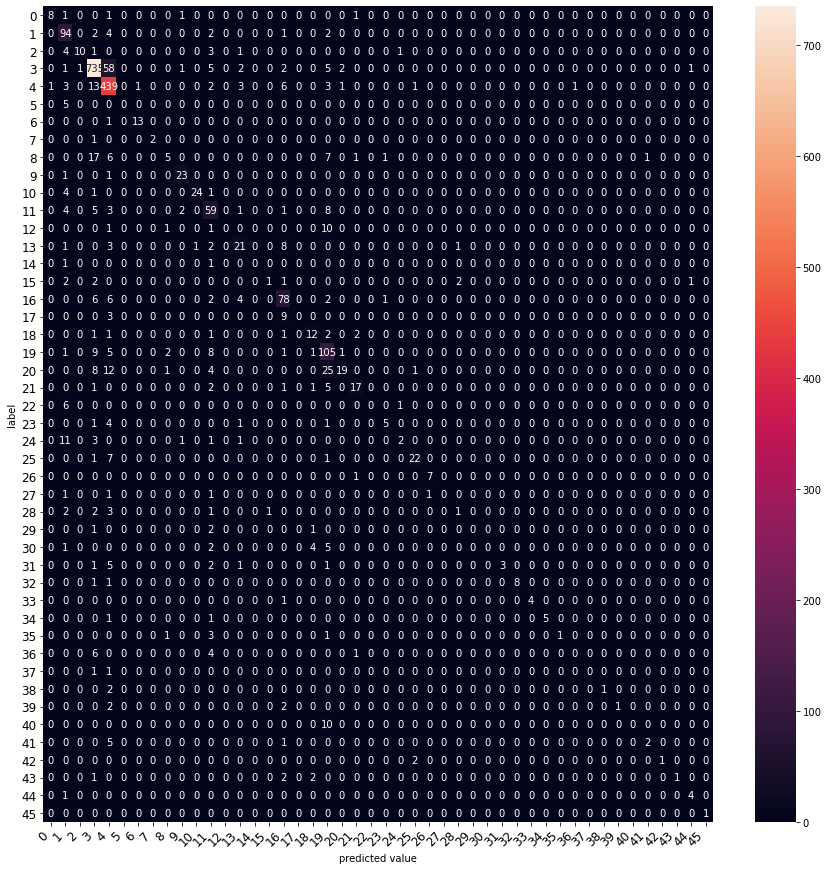

In [28]:
# CNB
print("[CNB]")
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[CNB의 Classification Report]")
print(classification_report(y_test, cb.predict(tfidfv_test)))
print("\n")
print("[CNB의 Confusion Matrix]")
graph_confusion_matrix(cb, tfidfv_test, y_test)

[로지스틱 회귀]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

정확도: 0.8125556544968834


[로지스틱 회귀의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.76      0.80      0.78       105
           2       0.71      0.75      0.73        20
           3       0.92      0.93      0.93       813
           4       0.80      0.87      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      1.00      0.97        14
           7       1.00      0.67      0.80         3
           8       0.65      0.74      0.69        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.64      0.75      0.69        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.83      0.56      0.67         9
          16       0.7

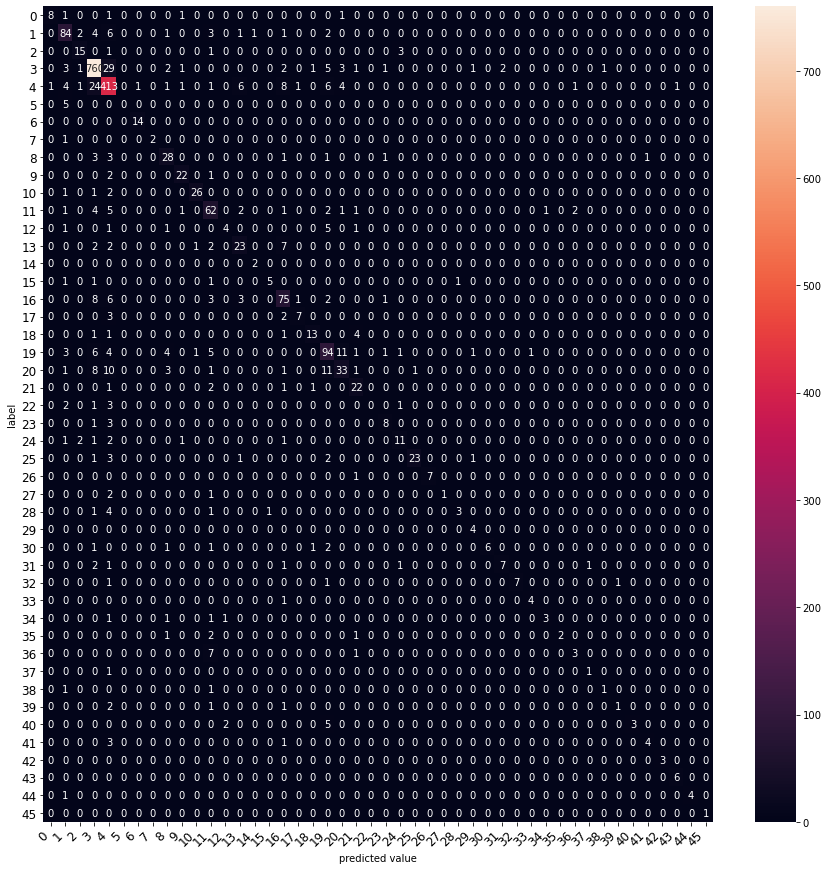

In [29]:
# 로지스틱 회귀
print("[로지스틱 회귀]")
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[로지스틱 회귀의 Classification Report]")
print(classification_report(y_test, lr.predict(tfidfv_test)))
print("\n")
print("[로지스틱 회귀의 Confusion Matrix]")
graph_confusion_matrix(lr, tfidfv_test, y_test)

[서포트 벡터 머신]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_class

정확도: 0.7747105966162066


[서포트 벡터 머신의 Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.69      0.70      0.69       105
           2       0.58      0.70      0.64        20
           3       0.91      0.92      0.91       813
           4       0.79      0.85      0.82       474
           5       0.00      0.00      0.00         5
           6       0.81      0.93      0.87        14
           7       0.50      0.33      0.40         3
           8       0.66      0.66      0.66        38
           9       0.90      0.76      0.83        25
          10       0.86      0.80      0.83        30
          11       0.61      0.76      0.68        83
          12       0.30      0.23      0.26        13
          13       0.58      0.59      0.59        37
          14       1.00      0.50      0.67         2
          15       0.67      0.22      0.33         9
          16       0

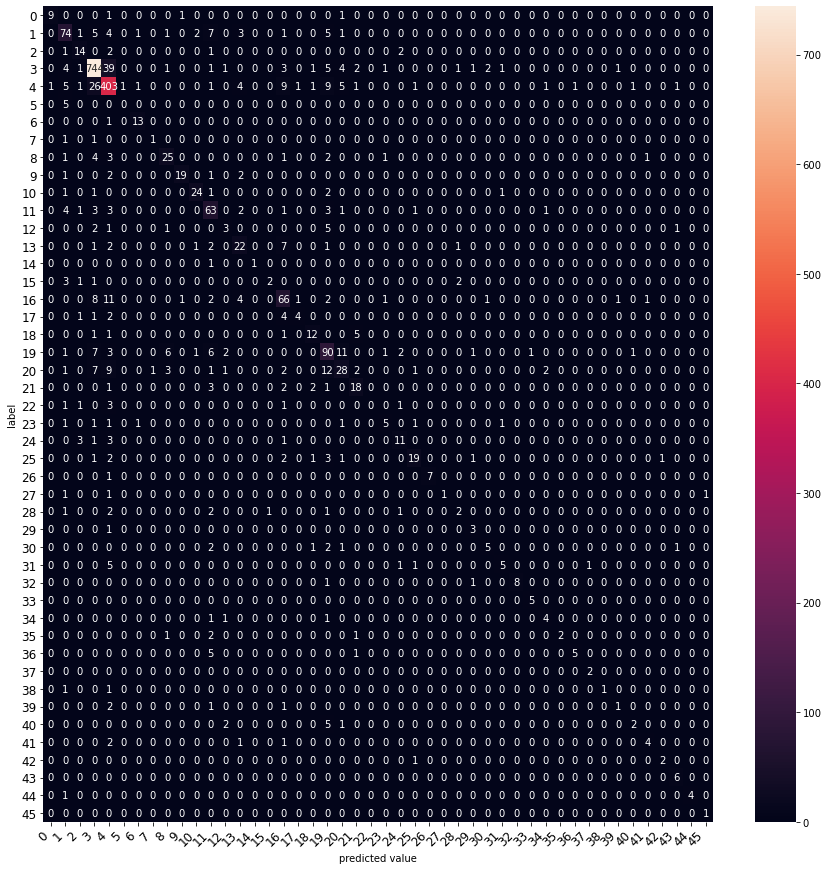

In [30]:
# 서포트 벡터 머신
print("[서포트 벡터 머신]")
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[서포트 벡터 머신의 Classification Report]")
print(classification_report(y_test, lsvc.predict(tfidfv_test)))
print("\n")
print("[서포트 벡터 머신의 Confusion Matrix]")
graph_confusion_matrix(lsvc, tfidfv_test, y_test)

[결정 트리]
정확도: 0.6193232413178985


[결정 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.73      0.42      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.83      0.88       813
           4       0.40      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.86      0.80      0.83        30
          11       0.64      0.49      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16    

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

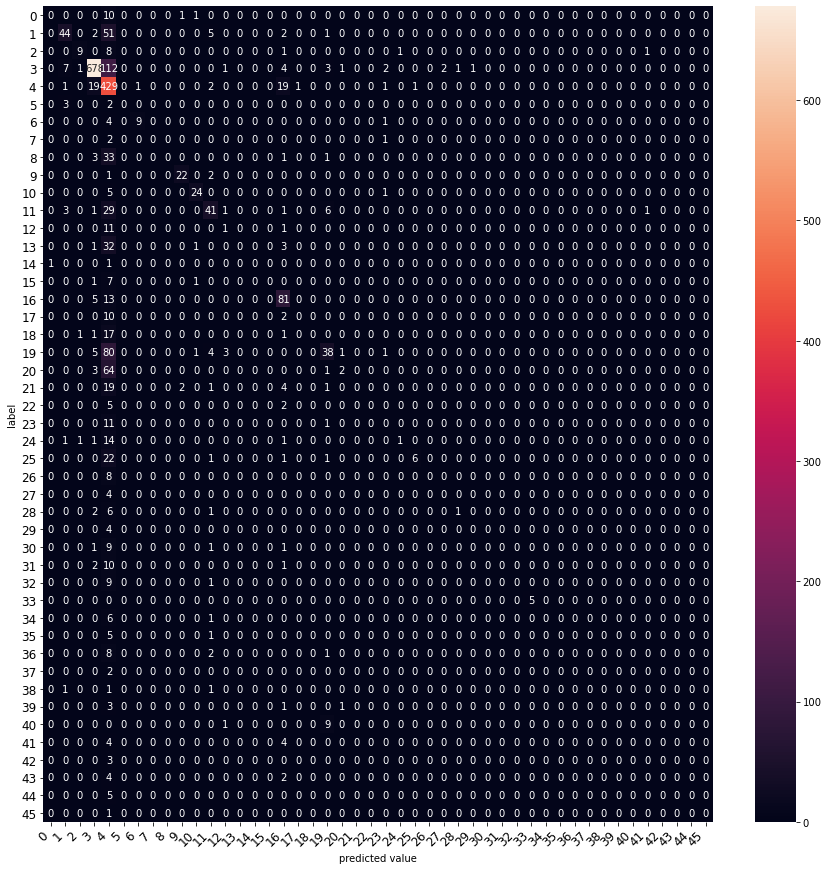

In [31]:
# 결정 트리
print("[결정 트리]")
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[결정 트리의 Classification Report]")
print(classification_report(y_test, tree.predict(tfidfv_test)))
print("\n")
print("[결정 트리의 Confusion Matrix]")
graph_confusion_matrix(tree, tfidfv_test, y_test)

[랜덤 포레스트]
정확도: 0.6714158504007124


[랜덤 포레스트의 Classification Report]
              precision    recall  f1-score   support

           0       0.25      0.50      0.33        12
           1       0.42      0.69      0.52       105
           2       0.13      0.10      0.11        20
           3       0.81      0.90      0.85       813
           4       0.65      0.85      0.74       474
           5       0.00      0.00      0.00         5
           6       0.83      0.36      0.50        14
           7       0.50      0.67      0.57         3
           8       0.62      0.53      0.57        38
           9       0.71      0.40      0.51        25
          10       0.60      0.20      0.30        30
          11       0.45      0.51      0.47        83
          12       0.60      0.23      0.33        13
          13       0.40      0.22      0.28        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

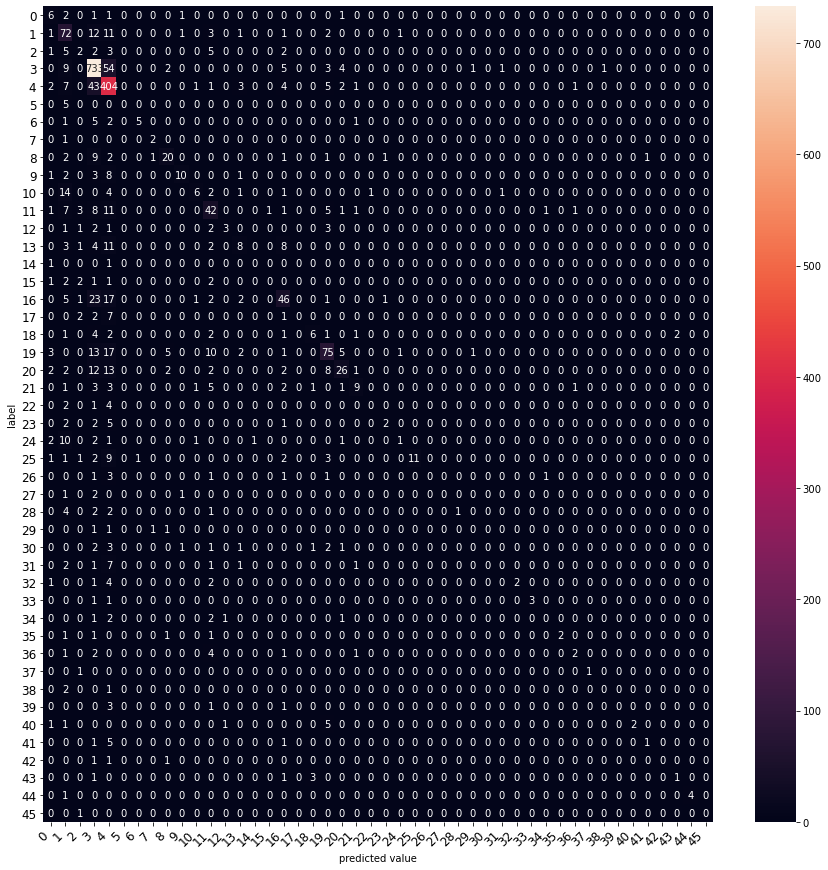

In [32]:
# 랜덤 포레스트
print("[랜덤 포레스트]")
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[랜덤 포레스트의 Classification Report]")
print(classification_report(y_test, forest.predict(tfidfv_test)))
print("\n")
print("[랜덤 포레스트의 Confusion Matrix]")
graph_confusion_matrix(forest, tfidfv_test, y_test)

[그래디언트 부스팅 트리]
정확도: 0.7707034728406055


[그래디언트 부스팅 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.70      0.75       105
           2       0.62      0.65      0.63        20
           3       0.87      0.91      0.89       813
           4       0.78      0.84      0.81       474
           5       0.00      0.00      0.00         5
           6       0.83      0.71      0.77        14
           7       1.00      0.67      0.80         3
           8       0.59      0.63      0.61        38
           9       0.86      0.76      0.81        25
          10       0.86      0.80      0.83        30
          11       0.64      0.67      0.66        83
          12       0.35      0.54      0.42        13
          13       0.54      0.41      0.46        37
          14       0.08      0.50      0.13         2
          15       0.38      0.33      0.35         9
  

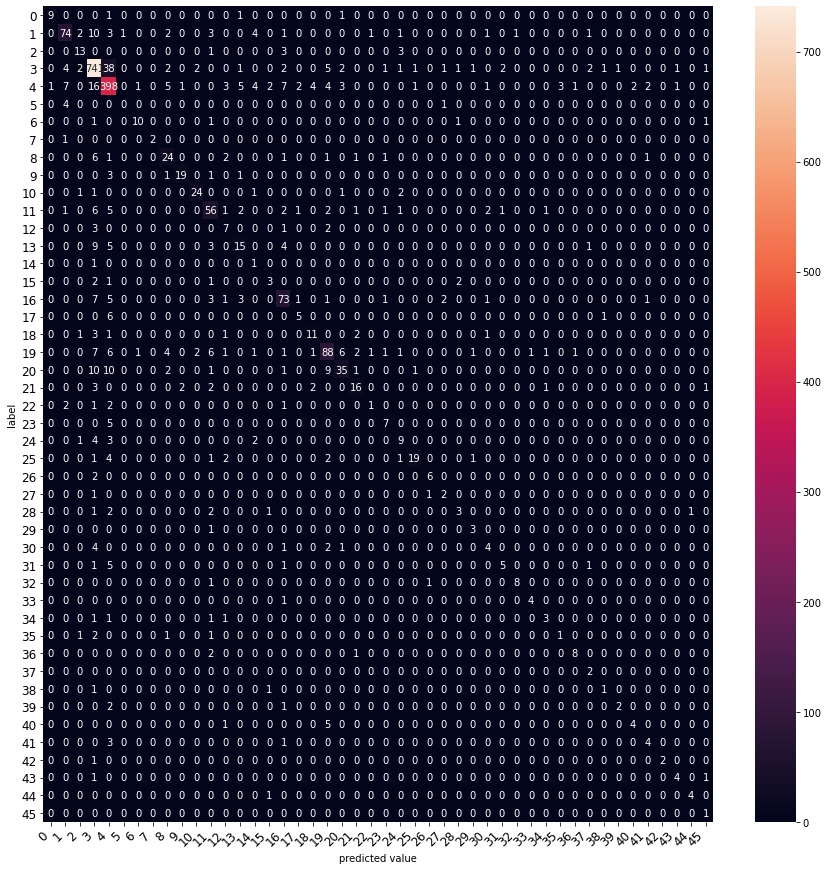

In [33]:
# 그래디언트 부스팅 트리
print("[그래디언트 부스팅 트리]")
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[그래디언트 부스팅 트리의 Classification Report]")
print(classification_report(y_test, grbt.predict(tfidfv_test)))
print("\n")
print("[그래디언트 부스팅 트리의 Confusion Matrix]")
graph_confusion_matrix(grbt, tfidfv_test, y_test)

[보팅]
정확도: 0.8165627782724845


[보팅의 Classification Report]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.78      0.75      0.77       105
           2       0.68      0.75      0.71        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.68      0.68        38
           9       0.81      0.88      0.85        25
          10       0.90      0.87      0.88        30
          11       0.68      0.72      0.70        83
          12       0.46      0.46      0.46        13
          13       0.68      0.62      0.65        37
          14       0.17      1.00      0.29         2
          15       0.57      0.44      0.50         9
          16       0.72      0.77      0.75        99
          17       0.73    

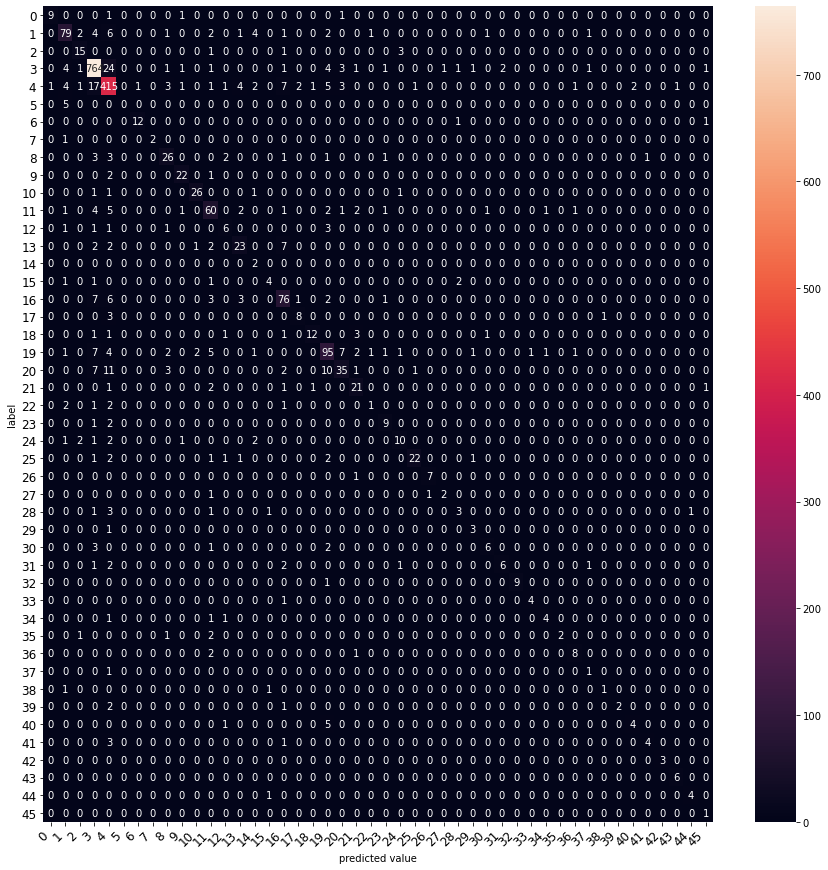

In [34]:
# 보팅
print("[보팅]")
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[보팅의 Classification Report]")
print(classification_report(y_test, voting_classifier.predict(tfidfv_test)))
print("\n")
print("[보팅의 Confusion Matrix]")
graph_confusion_matrix(voting_classifier, tfidfv_test, y_test)

- 우리는 노드에서 실습으로 num_words = 10000일 경우를 보았고, 프로젝트 1을 통해 모든 단어를 사용하기도 하고, 프로젝트 2를 통해 num_words = 5000일 경우도 보았다. 
- 그리고 직접 단어 개수를 설정해서 사용하는 경우 3가지에서 num_words = 20000일 경우와 num_words = 15000일 경우를 보았다. 나머지 한 경우는 5000보다 낮은 수인 3000으로 시도해보겠다.


### num_words = 3000일 경우

In [35]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=3000, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> <unk> <unk> said as a result of its december acquisition of <unk> co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and <unk> operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 2919)
(8982, 2919)


[나이브 베이즈 분류기]
- 정확도: 0.6874443455031166


[나이브 베이즈 분류기의 Classification Report]
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.49      0.82      0.61       105
           2       0.00      0.00      0.00        20
           3       0.88      0.88      0.88       813
           4       0.64      0.95      0.76       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.48      0.65        25
          10       1.00      0.10      0.18        30
          11       0.45      0.76      0.56        83
          12       0.00      0.00      0.00        13
          13       0.70      0.19      0.30        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
  

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

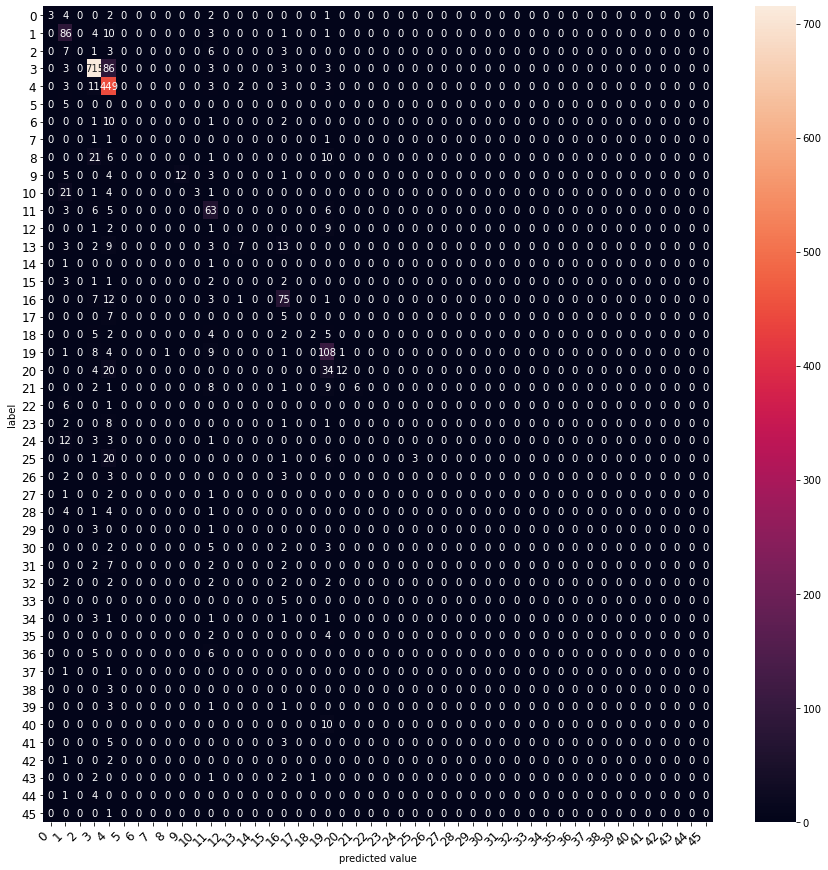

In [36]:
# 나이브 베이즈 분류기
print("[나이브 베이즈 분류기]")
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[나이브 베이즈 분류기의 Classification Report]")
print(classification_report(y_test, mod.predict(tfidfv_test)))
print("\n")      
print("[나이브 베이즈 분류기의 Confusion Matrix]")
graph_confusion_matrix(mod, tfidfv_test, y_test)

[CNB]
정확도: 0.7644701691896705


[CNB의 Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.64      0.85      0.73       105
           2       0.83      0.50      0.62        20
           3       0.92      0.89      0.90       813
           4       0.74      0.93      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.64      0.18      0.29        38
           9       0.82      0.92      0.87        25
          10       0.93      0.83      0.88        30
          11       0.52      0.78      0.62        83
          12       0.00      0.00      0.00        13
          13       0.68      0.62      0.65        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

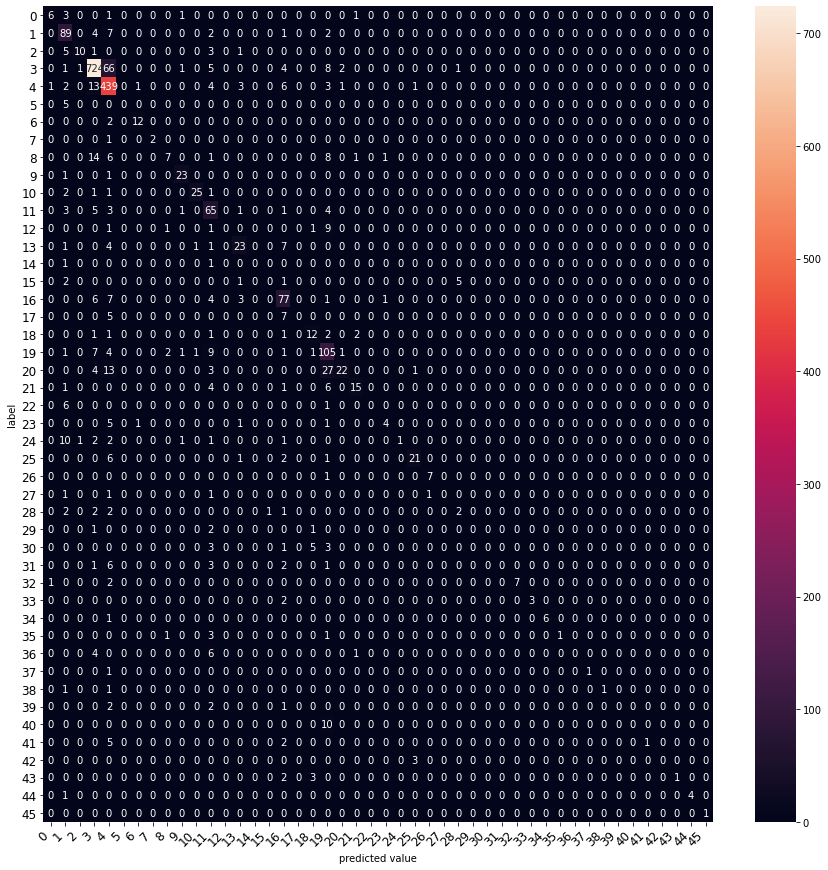

In [37]:
# CNB
print("[CNB]")
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[CNB의 Classification Report]")
print(classification_report(y_test, cb.predict(tfidfv_test)))
print("\n")
print("[CNB의 Confusion Matrix]")
graph_confusion_matrix(cb, tfidfv_test, y_test)

[로지스틱 회귀]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


정확도: 0.794746215494212


[로지스틱 회귀의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.75      0.76       105
           2       0.68      0.85      0.76        20
           3       0.91      0.92      0.91       813
           4       0.78      0.85      0.82       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.65      0.74      0.69        38
           9       0.81      0.84      0.82        25
          10       0.89      0.83      0.86        30
          11       0.60      0.69      0.64        83
          12       0.57      0.31      0.40        13
          13       0.59      0.65      0.62        37
          14       0.50      0.50      0.50         2
          15       0.83      0.56      0.67         9
          16       0.67

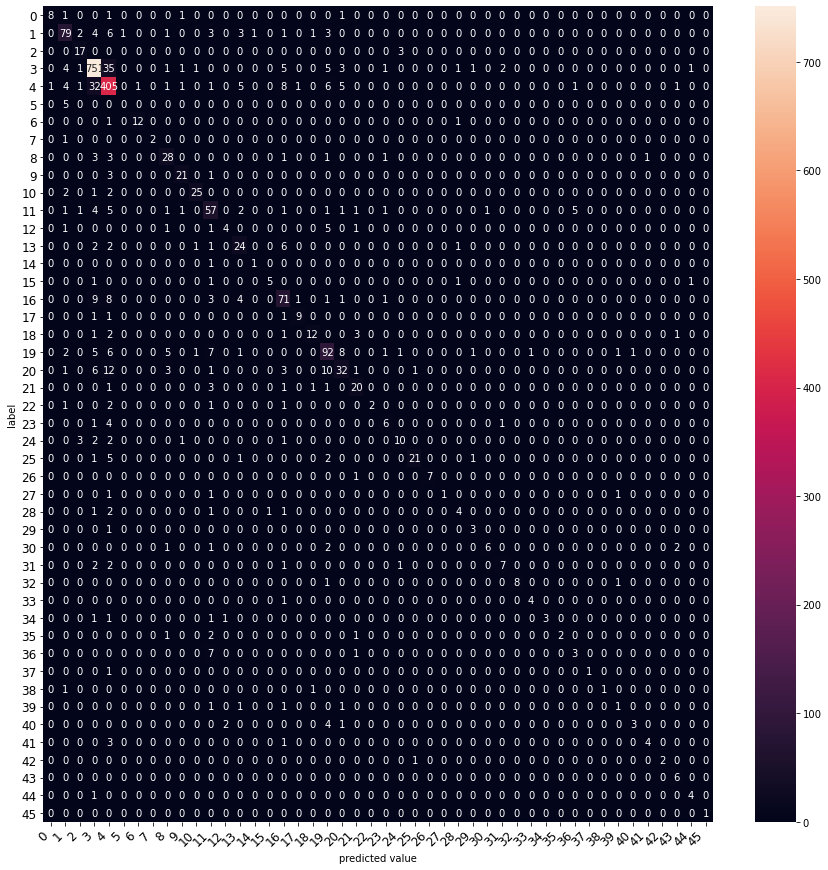

In [38]:
# 로지스틱 회귀
print("[로지스틱 회귀]")
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[로지스틱 회귀의 Classification Report]")
print(classification_report(y_test, lr.predict(tfidfv_test)))
print("\n")
print("[로지스틱 회귀의 Confusion Matrix]")
graph_confusion_matrix(lr, tfidfv_test, y_test)

[서포트 벡터 머신]


/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


정확도: 0.7471059661620659


[서포트 벡터 머신의 Classification Report]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.71      0.68      0.69       105
           2       0.68      0.65      0.67        20
           3       0.88      0.88      0.88       813
           4       0.79      0.81      0.80       474
           5       0.00      0.00      0.00         5
           6       0.88      1.00      0.93        14
           7       0.50      0.33      0.40         3
           8       0.62      0.63      0.62        38
           9       0.70      0.84      0.76        25
          10       0.79      0.87      0.83        30
          11       0.57      0.67      0.62        83
          12       0.33      0.38      0.36        13
          13       0.48      0.62      0.54        37
          14       1.00      0.50      0.67         2
          15       0.33      0.22      0.27         9
          16       0

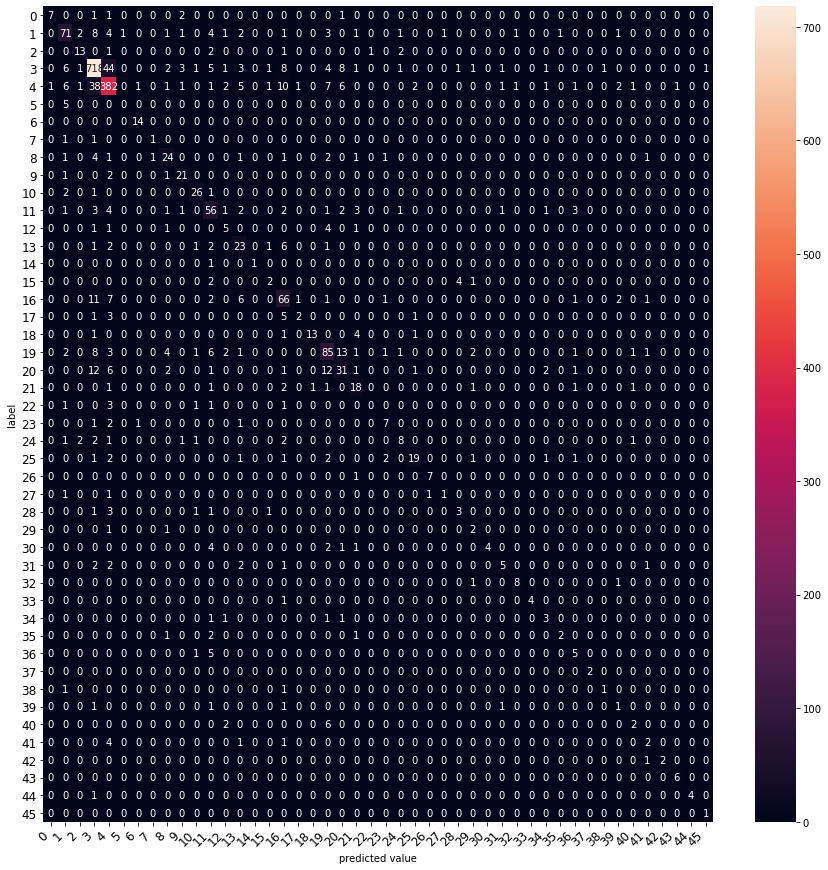

In [39]:
# 서포트 벡터 머신
print("[서포트 벡터 머신]")
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[서포트 벡터 머신의 Classification Report]")
print(classification_report(y_test, lsvc.predict(tfidfv_test)))
print("\n")
print("[서포트 벡터 머신의 Confusion Matrix]")
graph_confusion_matrix(lsvc, tfidfv_test, y_test)

[결정 트리]
정확도: 0.6260017809439002


[결정 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.39      0.51       105
           2       0.75      0.45      0.56        20
           3       0.94      0.84      0.89       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.59      0.52      0.55        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16    

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

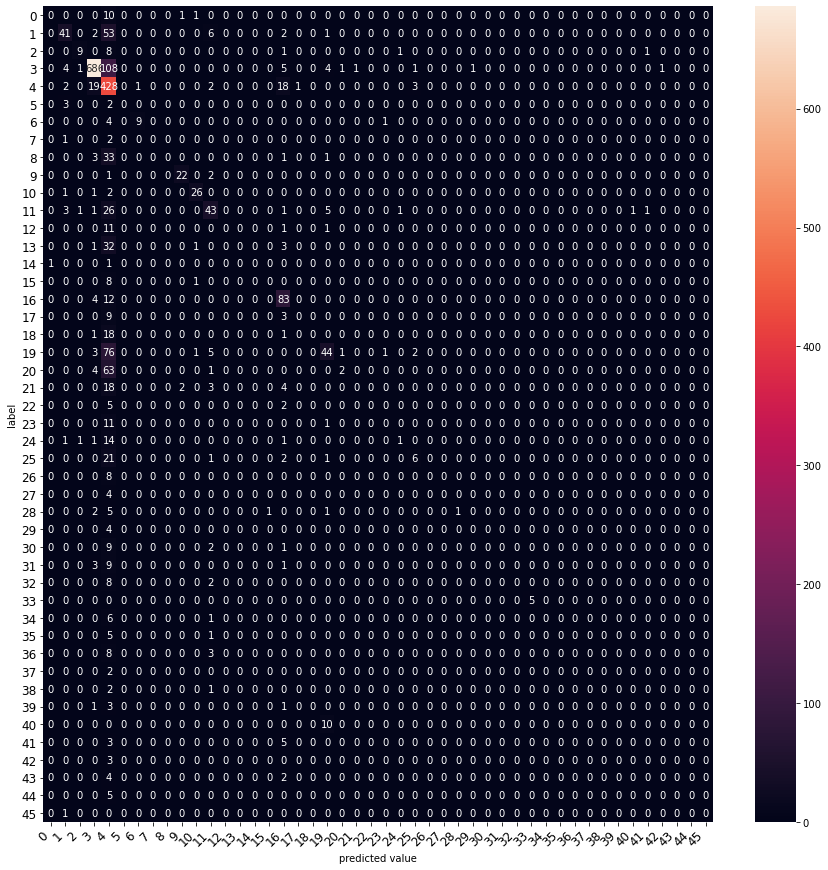

In [40]:
# 결정 트리
print("[결정 트리]")
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[결정 트리의 Classification Report]")
print(classification_report(y_test, tree.predict(tfidfv_test)))
print("\n")
print("[결정 트리의 Confusion Matrix]")
graph_confusion_matrix(tree, tfidfv_test, y_test)

[랜덤 포레스트]
정확도: 0.6856634016028496


[랜덤 포레스트의 Classification Report]
              precision    recall  f1-score   support

           0       0.30      0.58      0.40        12
           1       0.44      0.72      0.55       105
           2       0.12      0.10      0.11        20
           3       0.85      0.91      0.88       813
           4       0.66      0.83      0.73       474
           5       0.00      0.00      0.00         5
           6       0.67      0.57      0.62        14
           7       0.33      0.33      0.33         3
           8       0.54      0.53      0.53        38
           9       0.69      0.44      0.54        25
          10       0.72      0.43      0.54        30
          11       0.54      0.59      0.56        83
          12       0.50      0.15      0.24        13
          13       0.41      0.32      0.36        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

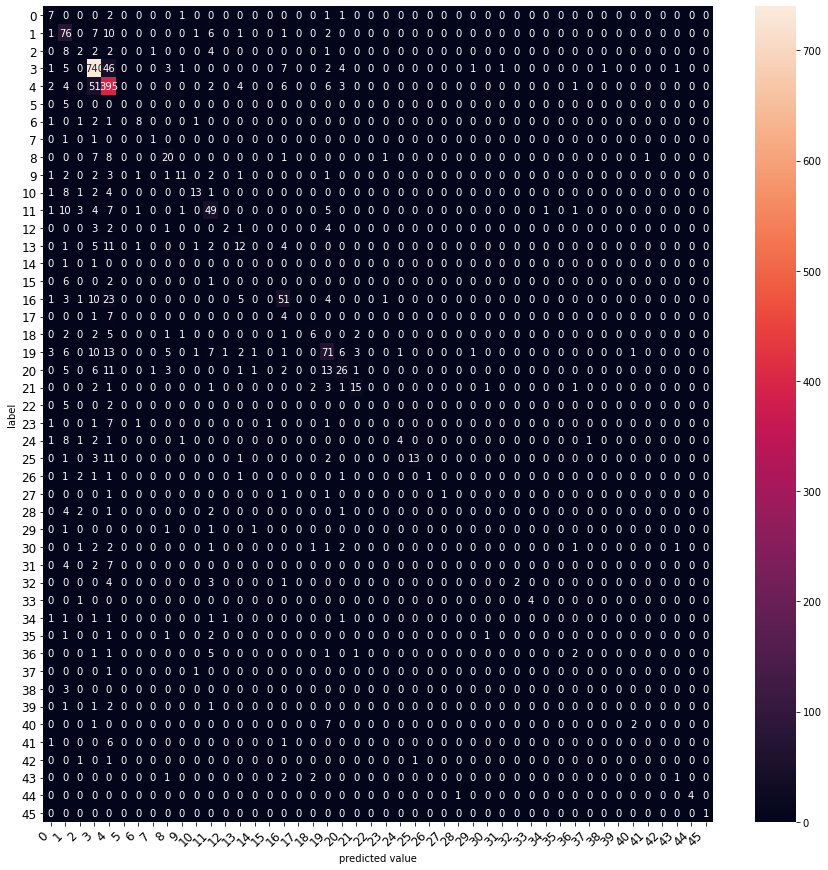

In [41]:
# 랜덤 포레스트
print("[랜덤 포레스트]")
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[랜덤 포레스트의 Classification Report]")
print(classification_report(y_test, forest.predict(tfidfv_test)))
print("\n")
print("[랜덤 포레스트의 Confusion Matrix]")
graph_confusion_matrix(forest, tfidfv_test, y_test)

[그래디언트 부스팅 트리]
정확도: 0.7756010685663401


[그래디언트 부스팅 트리의 Classification Report]
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.76      0.70      0.73       105
           2       0.67      0.70      0.68        20
           3       0.89      0.92      0.91       813
           4       0.77      0.84      0.80       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       0.20      0.33      0.25         3
           8       0.62      0.66      0.64        38
           9       0.90      0.76      0.83        25
          10       0.86      0.80      0.83        30
          11       0.66      0.69      0.67        83
          12       0.21      0.23      0.22        13
          13       0.54      0.41      0.46        37
          14       0.50      1.00      0.67         2
          15       0.50      0.22      0.31         9
  

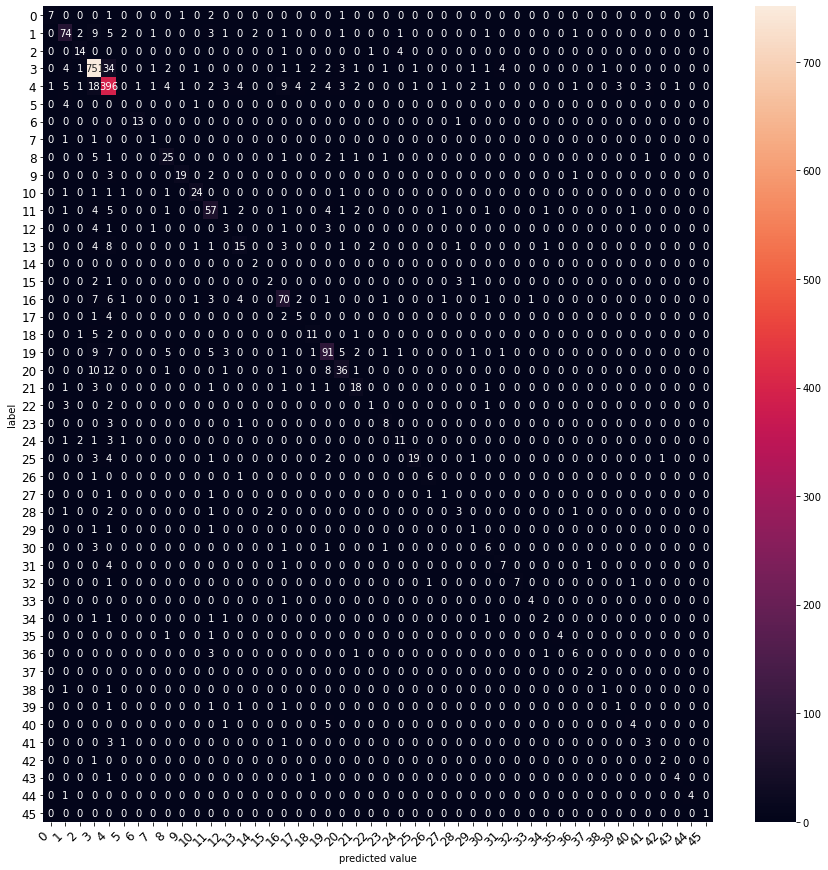

In [42]:
# 그래디언트 부스팅 트리
print("[그래디언트 부스팅 트리]")
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[그래디언트 부스팅 트리의 Classification Report]")
print(classification_report(y_test, grbt.predict(tfidfv_test)))
print("\n")
print("[그래디언트 부스팅 트리의 Confusion Matrix]")
graph_confusion_matrix(grbt, tfidfv_test, y_test)

[보팅]
정확도: 0.8103294746215495


[보팅의 Classification Report]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.78      0.77       105
           2       0.73      0.80      0.76        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.74      0.71        38
           9       0.80      0.80      0.80        25
          10       0.90      0.87      0.88        30
          11       0.65      0.70      0.67        83
          12       0.50      0.38      0.43        13
          13       0.62      0.62      0.62        37
          14       0.67      1.00      0.80         2
          15       0.67      0.44      0.53         9
          16       0.7

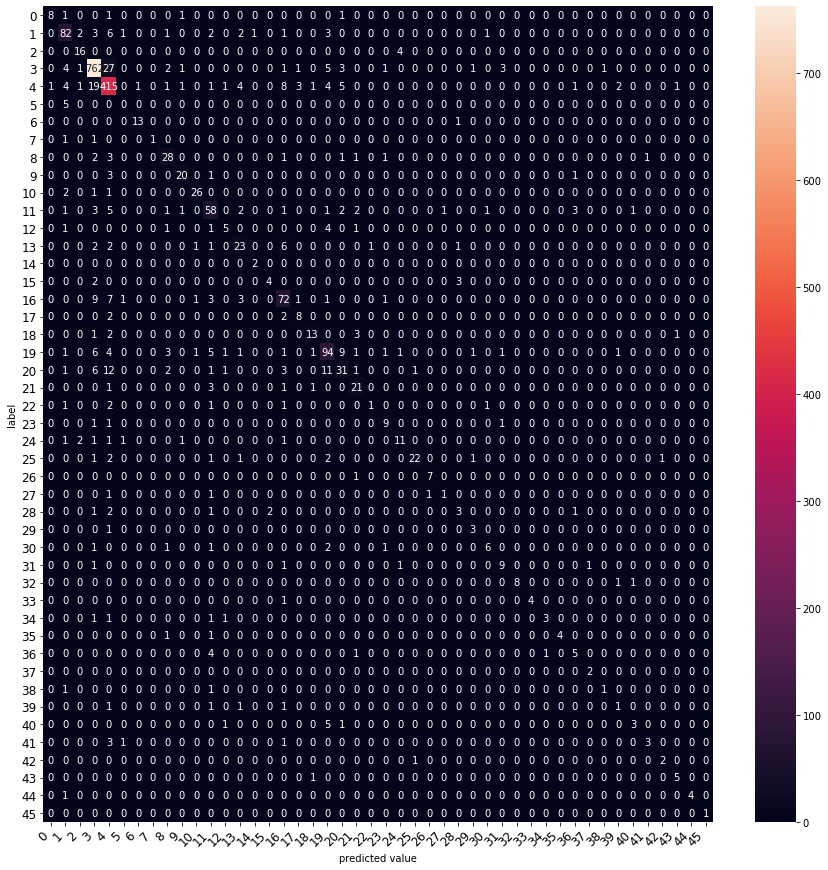

In [43]:
# 보팅
print("[보팅]")
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[보팅의 Classification Report]")
print(classification_report(y_test, voting_classifier.predict(tfidfv_test)))
print("\n")
print("[보팅의 Confusion Matrix]")
graph_confusion_matrix(voting_classifier, tfidfv_test, y_test)

- ```num_words```가 None(단어 전부 사용),20000, 15000, 10000, 5000, 3000일 경우에서 모델 9개의 성능을 평가하고 Confusion Matrixs를 히트맵으로 그려보았다.

- 다음은 단어 수와 분류기 모델마다 정확도와 F1 점수를 기입한 표이다.
- 정확도와 F1 점수 순서대로 콤마(,)를 기준으로 기입하고, F1 점수는 단순평균인 macro avg 점수를 기입했다.
- 모든 점수는 소수점 첫째 자리까지 나타내며 소수점 둘째 자리가 5이상이면 반올림했다.


||모든 단어|20000|15000|10000|5000|3000|
|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|
|나이브 베이즈 분류기|60%, 7%|62%, 8%|63%, 9%|66%, 10%|67%, 11%|69%, 14%|
|CNB|76%, 46%|77%, 46%|77%, 47%|77%, 48%|77%, 48%|76%, 44%|
|로지스틱 회귀|81%, 67%|81%, 66%|81%, 66%|81%, 64%|81%, 64%|79%, 65%|
|서포트 벡터 머신|79%, 59%|78%, 60%|77%, 59%|77%, 60%|77%, 57%|75%, 56%|
|결정 트리|62%, 15%|62%, 16%|62%, 18%|62%, 18%|62%, 18%|63%, 18%|
|랜덤 포레스트|65%, 28%|67%, 29%|67%, 30%|67%, 31%|70%, 36%|69%, 31%|
|그래디언트 부스팅 트리|77%, 57%|77%, 58%|77%, 57%|77%, 58%|77%, 58%|78%, 58%|
|보팅|82%, 66%|82%, 66%|82%, 65%|81%, 66%|82%, 66%|81%, 65%|

- 나는 ```로지스틱 회귀```가 가장 잘 나온 모델이라고 생각한다. 왜냐하면 훈련시간도 짧은데 ```그래디언트 부스팅 트리```나 ```보팅```만큼 정확도가 잘 나오기도 했고 F1 점수도 높기 때문이다. 


- 최적의 단어 수는 ```15000```이나 ```10000```이 모든 모델들의 점수를 봤을 때 가장 합리적으로 보인다. ```모든 단어```가 언뜻보면 가장 좋은 것처럼 보이지만 자세히 보면 ```모든 단어```에서 약세를 보이는 모델들이 있었기 때문이다. 나는 최적의 모델이라고 생각하는 ```로지스틱 회귀```에서 두번째로 좋은 성능을 보인 단어수 ```15000```을 최적의 단어수로 선정하겠다.

## 4. 딥러닝 모델과 비교하기

- 위 과정을 통해서 나온 최적의 모델과 단어 수 조건에서, 본인이 선택한 다른 모델을 적용한 결과와 비교해보자.
- 감정분석 등에서 사용했던 RNN이나 1-D CNN 등의 딥러닝 모델 중 하나를 선택해서 오늘 사용했던 데이터셋을 학습해보고 나오는 결과를 비교해보자.
- 단, 공정한 결과를 위해 이때 Word2Vec 등의 Pre-trained model은 사용하지 않도록 한다.

In [27]:
# RNN에 필요한 라이브러이 import
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

- 데이터를 분리한다. 이때 ```num_words=15000```으로 설정한다. 

In [41]:
"""
Pipe line
"""

# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

# 훈련과 시험 샘플 수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('시험 샘플의 수: {}'.format(len(x_test)))

# 정수 시퀀스 원래 뉴스 텍스트 데이터로 복원하기
word_index = reuters.get_word_index(path="reuters_word_index.json")

# 복원된 단어를 인덱스로 어떤 정수와 맵핑되는지 확인하기
print(word_index['the'])
print(word_index['it'])

# 실제 단어에 맵핑한 정수에 -3을 한 정수를 입력해서 각 정수에 +3하고 확인하기
index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # the
print(index_to_word[16]) # it

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어주기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
# index_to_word로 첫번째 훈련용 기사 원래 텍스트로 복원하기
print(' '.join([index_to_word[index] for index in x_train[0]]))

# 전체 훈련 데이터와 전체 시험 데이터를 텍스트 데이터로 변환하기
decoded= []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

# Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬로 벡터화하기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

훈련 샘플의 수: 8982
시험 샘플의 수: 2246
1
13
the
it
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
(8982, 14227)
(8982, 14227)


In [42]:
print(type(tfidfv))

<class 'scipy.sparse.csr.csr_matrix'>


In [43]:
import scipy
tfidfv = scipy.sparse.csr_matrix.toarray(tfidfv)

print(tfidfv)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0843303  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.09161547 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [44]:
print(y_train.shape)
print(y_test.shape)

(8982,)
(2246,)


In [47]:
y_train = to_categorical(y_train) # 훈련용 뉴스 기사 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 뉴스 기사 레이블의 원-핫 인코딩

In [48]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(1000, 120)) 
model.add(SimpleRNN(120)) 
model.add(Dense(46, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 120)         120000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 120)               28920     
_________________________________________________________________
dense_7 (Dense)              (None, 46)                5566      
Total params: 154,486
Trainable params: 154,486
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(tfidfv, y_train, epochs = 1)

281/281 [==============================] - 4270s 15s/step - loss: 0.1663 - accuracy: 0.2684


In [60]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

tfidfv_test = scipy.sparse.csr_matrix.toarray(tfidfv_test)

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
predicted = (predicted > 0.5) 

print("- 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print("\n")
print("[RNN의 Classification Report]")
print(classification_report(y_test, predicted))

- 정확도: 0.0


[RNN의 Classification Report]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00       105
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00       813
           4       0.00      0.00      0.00       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.00      0.00      0.00        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.00      0.00      

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

****
# 루브릭 평가

|평가문항|상세기준|
|:----|:----|
|1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|3. 생성모델의 metric(BLEU 등) 기준 이상 높은 성능이 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

1. 총 6가지 단어 개수(모든 단어, 20000, 15000, 10000, 5000, 3000)에 대해서 모델 8개를 모두 돌려봤다. 내가 선정한 최적의 솔루션은 로지스틱 회귀였다. 그래디언트 부스팅 트리나 보팅 만큼 성능이 잘 나오면서 빨랐기 때문이다.


2. 기준이 어디까지인지는 모르지만 그라디언트 부스팅 트리, 보팅, 로지스틱 회귀에 경우는 70~80% 대에 정확도를 갖는 성능을 보였다. 나이브 베이즈 분류기의 경우 F1 점수가 한 자리수로 나오기도 하던데, 그에 비하면 내가 언급한 3가지 분류기는 아주 일을 잘하는 것으로 볼 수 있다고 생각한다.


3. 딥러닝 모델을 바닐라 RNN으로 만들어서 돌리려고 했다. 그런데 입출력이 이전에 실습해본 분류기들이랑 다르게 TF-IDF 형태로 바꾼 행렬이 들어가지 않았다. 그래서 배열로 바꾸는 함수를 사용해서 간신히 모델을 돌릴 수 있었다. 그런데 epoch=1인데도 1시간 20분이 걸렸다. 뭔가 잘못됨을 느꼈지만 우선 돌아가서 뒀다. 그런데 이제 Classification Report를 생성하려는데 변수 predicted에 있는 값의 형태가 맞지 않는다고 에러가 나서 구글링을 한참했다. ```predicted = (predicted > 0.5) ```로 모면을 해서 리포트를 출력했지만 정확도가 0이 나오는 기염을 토해버렸다. 지금 잘못됨을 확실히 느꼈는데 뭐가 잘못된 것인지 모르겠다. 채점이 끝나면 퍼실님들께 질문해봐야겠다. 문뜩 나만 모델 만드는 걸 못하는 건가 생각이 스쳤다. 이제 아이펠 과정이 끝나가는데 모델 하나 못 만들고 입출력 크기도 잘 모른다니... 흑흑 내가 바보인건가...?

# 회고

1번, 2번 평가문항은 비교적 맞추기 쉬웠다. 노드에 주어진 코드로 돌리기만 하면 됐기 때문이다. 그런데 3번은 어려웠다. 인터넷에 로이터 뉴스 데이터로 뉴스 카테고리를 분류한 글은 많았지만 기존 데이터가 가진 정수 시퀀스를 이용해서 이번에 우리가 이용한 TF-IDF 형식과는 달랐다. 


나는 데이터에서 처음에 얻을 수 있는 정수 시퀀스가 TF-IDF 형식이 아니라고 생각해서 굳이 원래 텍스트 데이터로 돌려서 그걸 TF-IDF 형태로 바꿔서 사용했다. 이게 잘못된 것이었을까? 9개 모델은 잘 돌아가서 나는 여기서는 잘못됨을 느끼지 못했다. 잘한 것 같은데 3번 문제가 안 풀려서 잘못한 건가하는, 내 그동안의 행적에 대한 의구심이 생겼다.


3번은 도대체 어떻게 해야 되는 건지 나는 정말 모르겠다. 오늘 게더에서 물어보려고 했는데 오늘 저녁은 금요일이라 그런지 사람들이 없어서 물어보지 못했다.


그래도 모델이 안 돌아간 채로 낼 줄 알았는데 입출력 요건은 맞춰서 돌릴 수 있었다. 이런 걸 보면 컴퓨터는 컴퓨터가 맞는 것 같다. 모양만 맞추면 계산을 해준다니 말이다. 조금 웃긴 부분이다. 